# Import librairies

In [80]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

import pydot
import graphviz
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import time
from pprint import pprint

from sklearn.datasets import fetch_california_housing 
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score


import talos
import keras
from talos import Evaluate
from talos import Predict
from talos import Reporting

print(tf.__version__)

1.14.0


# Load Data

In [2]:
windows_new = False

path1 = 'C:/Users/letou/Documents/'
path2 = 'C:/Users/louis/OneDrive/Documents/'

if windows_new == True:
    path = path2
else:
    path = path1
D17_observations = pd.read_pickle(path+'IGE/Data/aws/D17_observations.pkl')
D17_profiles = pd.read_pickle(path+'IGE/Data/aws/D17_profiles.pkl')
D17_total = pd.read_pickle(path+'IGE/Data/aws/D17_total.pkl')
D17_profiles.index = D17_profiles.index - pd.DateOffset(minutes = 15)
MAR = pd.read_pickle(path+'IGE/Data/MAR/MAR_ERA5.pkl')
MAR_no_BS_ERA5 = pd.read_pickle(path+'IGE/Data/MAR/MAR_no_BS_ERA5.pkl')

# Preprocessing Data

In [3]:
# Temperatures in degrees
D17_observations['T2m'] = D17_observations['T2m'] + 273
D17_total['T1'] = D17_total['T1'] + 273
D17_total['T2'] = D17_total['T2'] + 273
D17_total['T3'] = D17_total['T3'] + 273
D17_total['T4'] = D17_total['T4'] + 273
D17_total['T5'] = D17_total['T5'] + 273
D17_total['T6'] = D17_total['T6'] + 273

# Delete wrong values
D17_total['RH1'][D17_total['RH1'] < 0] = np.NaN
D17_total['RH2'][D17_total['RH2'] < 0] = np.NaN
D17_total['RH3'][D17_total['RH3'] < 0] = np.NaN
D17_total['RH4'][D17_total['RH4'] < 0] = np.NaN
D17_total['RH5'][D17_total['RH5'] < 0] = np.NaN
D17_total['RH6'][D17_total['RH6'] < 0] = np.NaN

# Predict FC_2

In [4]:
variables_FC2 = ['FC1','RH1', 'RH2', 'RH3', 'RH4', 'RH5', 'RH6', 'U1', 'U2', 'U3', 'U4','FC2']
Dataset_FC2 = D17_total[variables_FC2].dropna()

# Training set before 2018
X_train_FC2 = Dataset_FC2[variables_FC2[:-1]][(Dataset_FC2.index.year >= 2013) & (Dataset_FC2.index.year <= 2017)]
y_train_FC2 = Dataset_FC2[variables_FC2[-1]][(Dataset_FC2.index.year >= 2013) & (Dataset_FC2.index.year <= 2017)]

# Testing set in 2018
X_test_FC2 = Dataset_FC2[variables_FC2[:-1]][(Dataset_FC2.index.year == 2018)]
y_test_FC2 = Dataset_FC2[variables_FC2[-1]][(Dataset_FC2.index.year == 2018)]

# Prediction before 2013
X_predict_FC2 = Dataset_FC2[variables_FC2[:-1]][(Dataset_FC2.index.year <= 2013)]

In [5]:
# Predict using a Random Forest
from sklearn.ensemble import RandomForestRegressor
rnd_clf = RandomForestRegressor(n_estimators=10) 
rnd_clf.fit(X_train_FC2, y_train_FC2) 
y_pred_rf = rnd_clf.predict(X_test_FC2)

# Test score
from sklearn.metrics import mean_squared_error
print('RMSE FC2 prediction: \n')
mean_squared_error(y_test_FC2, y_pred_rf)**(0.5)

RMSE FC2 prediction: 



47.80609740916268

In [6]:
# Store prediction
y_pred2_FC2 = rnd_clf.predict(X_predict_FC2)

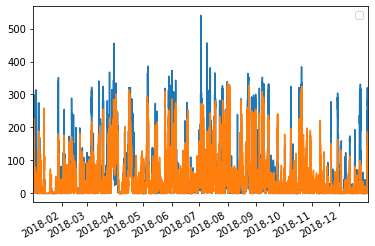

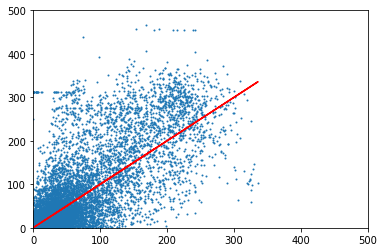

In [7]:
# Plot test set
ax = plt.gca()
y_test_FC2.plot(ax=ax)
y_pred_rf = pd.DataFrame(y_pred_rf)
y_pred_rf.index = y_test_FC2.index
y_pred_rf.plot(ax=ax)

x = y_pred_rf.values
y = y_test_FC2.values
plt.legend('Observed', 'Predicted')

plt.figure()
ax = plt.gca()
ax.set_ylim(0,500)
ax.set_xlim(0,500)
plt.scatter(x,y, s=1)
plt.plot(x,x,color='red')


# Integrate FC2 to the working dataset and calculate FC

In [8]:
# Integrate FC2
y_pred2_FC2 = pd.DataFrame({'FC2':y_pred2_FC2})
y_pred2_FC2.index = X_predict_FC2.index
D17_total.update(y_pred2_FC2)

# Calculate FC
D17_total['hFC1'][D17_total['hFC1']<0] = 0
D17_total['hFC1'][D17_total['hFC1']>1] = 1

D17_total['FC_2'] = (D17_total['FC1']+D17_total['FC2'])/2
D17_total['FC_2'][D17_total['hFC1']<1] = (D17_total['FC1']*D17_total['hFC1']+D17_total['FC2']) / (D17_total['hFC1']+1)


# Delete constant values

In [9]:
# 25/12/2015

# FC = 314.48 for 7 hours on the 25th of December 2012
# D17_observations['FC_2'][(D17_observations.index.year == 2015) & (D17_observations.index.month == 12) & (D17_observations.index.day >= 25) & (D17_observations.index.day <= 26)][40:90]
D17_observations['FC_2'][(D17_observations.index.year == 2015) & (D17_observations.index.month == 12) & (D17_observations.index.day >= 25) & (D17_observations.index.day <= 26)] = np.NaN
D17_total['FC_2'][(D17_total.index.year == 2015) & (D17_total.index.month == 12) & (D17_total.index.day >= 25) & (D17_total.index.day <= 26)] = np.NaN



# 06/01/2018

# FC = for 13 hours on the 3rd of December 2018
D17_total['FC_2'][(D17_total.index.year == 2018) & (D17_total.index.month == 1) & (D17_total.index.day >= 3) & (D17_total.index.day <= 4)] = np.NaN

# FC = 183.06 for 18 hours on the 6th of December 2018
# D17_observations['FC_2'][(D17_observations.index.year == 2018) & (D17_observations.index.month == 1) & (D17_observations.index.day >= 6) & (D17_observations.index.day <= 8)][30:90]
D17_total['FC_2'][(D17_total.index.year == 2018) & (D17_total.index.month == 1) & (D17_total.index.day >= 6) & (D17_total.index.day <= 8)] = np.NaN

# Insert snowfall as a predictive variable

In [10]:
D17_total['SF'] = MAR_no_BS_ERA5['SF']

# Computing gradient of sensor heights to approximate snow accumulation

In [11]:
var_height = ['zT1', 'zT2', 'zT3', 'zT4', 'zT5', 'zT6']
for variable in var_height:
    D17_total['gradient_' + variable] = D17_total[variable].diff()
    D17_total['gradient_' + variable][(abs(D17_total['gradient_' + variable]) > 0.10)] = np.NaN

# Computing verical gradients

In [12]:
for k in range(3):
    if k == 0:
        D17_total['vert_grad_RH'] = D17_total['RH1'] - D17_total['RH6']
    if k == 1:
        D17_total['vert_grad_T'] = D17_total['T1'] - D17_total['T6']
    if k == 2:
        D17_total['vert_grad_U'] = D17_total['U1'] - D17_total['U6']

# Calculate rolling means

In [13]:
window = "7D"
for variable in list(D17_total.columns):
    D17_total['rolling_mean_' + variable] = D17_total[variable].rolling(window).mean()
    D17_total['rolling_sum_' + variable] = D17_total[variable].rolling(window).sum()

# Select input variables

In [14]:
#D17_observations.columns
#D17_profiles.columns
#zU3 and zT4 for 2m levels
#D17_total.columns

In [15]:
#variables = ['SWU', 'SWD', 'LWU', 'LWD','U2m','T2m','RH2m','FC_2','zT', 'zU', 'U1', 'U2', 'zT1', 'zT2', 'zU1', 'zU2', 'T1',
#       'T2', 'RH1', 'RH2']
#variables = ['U2m','T2m','FC_2','zT', 'zU']
variables = ['T1', 'RH1', 'T4', 'RH4', 'U4', 'rolling_mean_T1' , 'rolling_mean_RH1', 'rolling_mean_U1', 'gradient_zT4', 'vert_grad_RH', 'vert_grad_T', 'vert_grad_U', 'rolling_sum_gradient_zT4','FC_2']
#variables = ['RH1', 'RH2', 'RH3', 'RH4', 'RH5', 'RH6',
#       'T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'U1', 'U2', 'U3', 'U4',
#       'zT1', 'zT2', 'zT3', 'zT4', 'zT5', 'zT6', 'zU1', 'zU2', 'zU3', 'zU4', 'SF', 'FC_2']

Dataset = D17_total[variables]
Dataset = Dataset.dropna()

#  Split training, validation, test

In [16]:
#X_train_full, X_test, y_train_full, y_test = train_test_split( D17_observations_1, D17_observations_2)
#X_train, X_valid, y_train, y_valid = train_test_split( X_train_full, y_train_full)

In [17]:
year_max = 2018

X_train = Dataset[variables[:-1]][(Dataset.index.year < year_max)].values
X_test = Dataset[variables[:-1]][(Dataset.index.year == year_max)].values

y_train = Dataset['FC_2'][(Dataset.index.year < year_max)].values
y_test = Dataset['FC_2'][(Dataset.index.year == year_max)].values

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.001)


# Scale

In [18]:
scaler = StandardScaler() 
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid) 
X_test_scaled = scaler.transform(X_test)

# Neural Network

#### Model

In [19]:
# True for CV search, False for single model
cv_search_choice = True
return_best_dnn_fit = False

def CV_search(n):

    ''' 
    _____________________________________________________________
    _____________________________________________________________
    _______ Function use to define if p should be the shape _____
    ____________________ of CV search or not_____________________
    _____________________________________________________________

    '''


    if n == True:
        p = {

            # 1 = Classic, 2= Concatenate, 3 = BatchNormalization
            "architecture": [2],

            # For architecture 1 and 2
            "n_layers": [4],
            "n_neurons": [100, 200],

            # Nadam, SGD RMSpop, Adagrad, Adadelta, Adam, Adamax, Nadam
            "optimizer": ["Nadam"],

            # Zeros, Ones, Constant, RandomNormal, RandomUniform, TruncatedNormal, VarianceScaling,
            # Orthogonal, Identity, lecun_uniform, glorot_normal, glorot_uniform, he_normal, lecun_normal, he_uniform
            'kernel_initializer': ["lecun_uniform"],

            # elu, softmax, selu, softplus, softsign, relu, tanh, sigmoid, hard_sigmoid, exponential, linear
            'activation': ["tanh"],
            "learning_rate": [0.001], 
            'batch_size': [30],
            'epochs': [20],
            'dropout': [0],
            "loss": ["mean_squared_error"],
            "fit": [True]}



    if n == False:
        p = {

            # 1 = Classic, 2= Concatenate, 3 = BatchNormalization
            "architecture": 1, 

            # For architecture 1 and 2
            "n_layers": 4,
            "n_neurons": 300,
            "optimizer": "Nadam",
            'kernel_initializer': "lecun_uniform",
            'activation': "tanh",
            "learning_rate":0.01, 
            'batch_size': 20,
            'epochs': 100,
            'dropout': 0,
            "loss": "mean_squared_error",
            "fit": False}


    return(p)

p = CV_search(cv_search_choice)

In [20]:
def choose_optimizer(name, learning_rate):

  ''' 
    _____________________________________________________________
    _____________________________________________________________
    _______ Function use to CV search the best optimizer ________
    __________Input = Name, Leaning rate_________________________
    _____________________________________________________________
  '''


  if name == "SGD":
    return(keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.0, nesterov=False))
  
  if name == "RMSprop":
    return(keras.optimizers.RMSprop(learning_rate=learning_rate, rho=0.9))

  if name == "Adagrad":
    return(keras.optimizers.Adagrad(learning_rate=learning_rate))

  if name == "Adadelta":
    return(keras.optimizers.Adadelta(learning_rate=learning_rate, rho=0.95))

  if name == "Adam":
    return(keras.optimizers.Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, amsgrad=False))

  if name == "Adamax":
    return(keras.optimizers.Adamax(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999))

  if name == "Nadam":
    return(keras.optimizers.Nadam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999))

In [21]:
def build_model(X_train, y_train, X_valid_scaled, y_valid, params):
    
    ''' 
    _____________________________________________________________
    _____________________________________________________________
    _________________     Classic        ________________________
    _____________________________________________________________
    _____________________________________________________________
    '''


    if params["architecture"] == 1:
      
      #______________   Building model   ___________________________
        model = keras.models.Sequential() 
        options = {"input_shape": X_train.shape[1:]} 

      #______________   Adding layers   ____________________________
        for layer in range(params['n_layers']):
            model.add(keras.layers.Dense(params['n_neurons'], 
                                      activation= params['activation'],
                                      kernel_initializer=params['kernel_initializer'], 
                                      **options)) 
            options = {}

        #______________   Output layer   _____________________________
        model.add(keras.layers.Dense(1,
                                  kernel_initializer=params['kernel_initializer'],
                                  **options)) 
      
        #______________   Choosing optimizer   _______________________
        optimizer = choose_optimizer(params["optimizer"], params["learning_rate"])

        #__________________   Compiling   ____________________________
        model.compile(loss=params["loss"], optimizer=optimizer)
    
    





    
    ''' 
    _____________________________________________________________
    _____________________________________________________________
    _________________     Concatenate        ____________________
    _____________________________________________________________
    _____________________________________________________________
    '''


    if params["architecture"] == 2:
        
        #______________   Building model   ___________________________
        model = keras.models.Sequential() 
        input = keras.layers.Input(shape=X_train.shape[1:]) 

        #______________   Adding layers   ____________________________
        hidden = keras.layers.Dense(params['n_neurons'], activation=params['activation'], kernel_initializer=params['kernel_initializer'])(input) 
        for layer in range(params['n_layers']-1): 
            hidden = keras.layers.Dense(params['n_neurons'], activation=params['activation'], kernel_initializer=params['kernel_initializer'])(hidden)
      
        #______________   Concatenate   ____________________________
        concat = keras.layers.Concatenate()([input, hidden]) 

        #______________   Output layer   _____________________________
        output = keras.layers.Dense(1)(concat) 
        model = keras.models.Model(inputs=[input], outputs=[output])

        #______________   Choosing optimizer   _______________________
        optimizer = choose_optimizer(params["optimizer"], params["learning_rate"])

        #__________________   Compiling   ____________________________
        model.compile(loss=params["loss"], optimizer=optimizer)











    ''' 
    _____________________________________________________________
    _____________________________________________________________
    _________________  Batch Normalization   ____________________
    ___for deeper networks it can make a tremendous difference___
    _____________________________________________________________
    '''
    
    
    if params["architecture"] == 3:
      
      #______________   Building model   ___________________________
        model = keras.models.Sequential([ 
        keras.layers.Flatten(input_shape=X_train.shape[1:]),
        keras.layers.BatchNormalization(), 
        keras.layers.Dense(300, activation=params['activation'], kernel_initializer=params['kernel_initializer']),
        keras.layers.BatchNormalization(), 
        keras.layers.Dense(200, activation=params['activation'], kernel_initializer=params['kernel_initializer']), 
        keras.layers.BatchNormalization(), 
        keras.layers.Dense(100, activation=params['activation'], kernel_initializer=params['kernel_initializer']), 
        keras.layers.BatchNormalization(), 
        keras.layers.Dense(5, activation=params['activation'], kernel_initializer=params['kernel_initializer']), 
        keras.layers.BatchNormalization(), 
        keras.layers.Dense(1)])

        #______________   Choosing optimizer   _______________________
        optimizer = choose_optimizer(params["optimizer"], params["learning_rate"])

        #__________________   Compiling   ____________________________
        model.compile(loss=params["loss"], optimizer=optimizer)

    if (params["fit"] == True) and (return_best_dnn_fit == False):
        history = model.fit(X_train, y_train, validation_data=[X_valid_scaled, y_valid],batch_size=params['batch_size'],epochs=params['epochs'],verbose=0)
        return history, model
    if (params["fit"] == True) and (return_best_dnn_fit == True):
        best_dnn = model
        return(best_dnn)
    else:
        return 0, model

In [22]:
if cv_search_choice == False:
  start_time = time.time()
  '''
  # Distribution strategies
  tf.config.experimental_connect_to_host('grpc://' + os.environ['COLAB_TPU_ADDR'])
  resolver = tf.distribute.cluster_resolver.TPUClusterResolver('grpc://' + os.environ['COLAB_TPU_ADDR'])
  tf.tpu.experimental.initialize_tpu_system(resolver)
  strategy = tf.distribute.experimental.TPUStrategy(resolver) 
  
  
  print("--- %s seconds for building model" % (time.time() - start_time))
  start_time = time.time()
  model.fit(X_train_scaled,
          epochs=5,
          validation_data=[X_valid_scaled, y_valid],
          batch_size=5)
  '''
  [history, model] = build_model(X_train_scaled, y_train, X_valid_scaled, y_valid, p)
  from livelossplot.keras import PlotLossesCallback
  model.fit(X_train_scaled, y_train, validation_data=[X_valid_scaled, y_valid],batch_size=p['batch_size'],epochs=p['epochs'], callbacks=[PlotLossesCallback()])
  
  print("--- %s seconds for fitting model" % (time.time() - start_time))
else:
    return_best_dnn_fit = False
    t = talos.Scan(x=X_train_scaled, y=y_train, params=p, model=build_model, experiment_name='DNN_snow_mass_fluxes', print_params=True)
    talos_data = t.data.sort_values(by=['val_loss'])
    print('\n\n')
    print(talos_data)

    # Reporting
    print('\n\n')
    windows_new = True
    if windows_new == True:
        experiment_log_list = !dir -lhtr DNN_snow_mass_fluxes
        experiment_log = experiment_log_list[-3].split()[-1]
    else:
      experiment_log_list = !ls -lhtr DNN_snow_mass_fluxes
      experiment_log = experiment_log_list[-1].split()[-1]
    r = Reporting('DNN_snow_mass_fluxes/'+experiment_log)
    print('\n\n')
    print("Number of rounds it took to find best model: {}".format(r.rounds2high('val_loss')))
    print('\n\n')
    print('Best model parameters: ')
    best_model_parameters = pd.DataFrame(talos_data.iloc[0,:]).transpose()
    print(pd.DataFrame(talos_data.iloc[0,:]).transpose())

    # Exporting best model
    best_model_parameters_export = best_model_parameters.iloc[0,:].to_dict()
    best_model_parameters = best_model_parameters.iloc[0,:].to_dict()
    best_model_parameters.update({'fit' : True})
    best_model_parameters_export.update({'fit' : False})
    [history, model] = build_model(X_train_scaled, y_train, X_valid_scaled, y_valid, best_model_parameters)
    return_best_dnn_fit = True
    best_dnn = build_model(X_train_scaled, y_train, X_valid_scaled, y_valid, best_model_parameters)

  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

{'activation': 'tanh', 'architecture': 2, 'batch_size': 30, 'dropout': 0, 'epochs': 20, 'fit': True, 'kernel_initializer': 'lecun_uniform', 'learning_rate': 0.001, 'loss': 'mean_squared_error', 'n_layers': 4, 'n_neurons': 100, 'optimizer': 'Nadam'}



 50%|██████████████████████████████████████████                                          | 1/2 [01:02<01:02, 62.47s/it]

{'activation': 'tanh', 'architecture': 2, 'batch_size': 30, 'dropout': 0, 'epochs': 20, 'fit': True, 'kernel_initializer': 'lecun_uniform', 'learning_rate': 0.001, 'loss': 'mean_squared_error', 'n_layers': 4, 'n_neurons': 200, 'optimizer': 'Nadam'}


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:39<00:00, 79.61s/it]





   round_epochs    val_loss       loss activation  architecture  batch_size  \
1            20  295.185307  211.95885       tanh             2          30   
0            20  307.708771  237.23963       tanh             2          30   

   dropout  epochs   fit kernel_initializer  learning_rate  \
1        0      20  True      lecun_uniform          0.001   
0        0      20  True      lecun_uniform          0.001   

                 loss  n_layers  n_neurons optimizer  
1  mean_squared_error         4        200     Nadam  
0  mean_squared_error         4        100     Nadam  






Number of rounds it took to find best model: 0



Best model parameters: 
  round_epochs val_loss     loss activation architecture batch_size dropout  \
1           20  295.185  211.959       tanh            2         30       0   

  epochs   fit kernel_initializer learning_rate                loss n_layers  \
1     20  True      lecun_uniform         0.001  mean_squared_error        4   

  n_neu

#### Evaluation

In [23]:
y_MAR = MAR['FC'][MAR.index.isin(D17_observations.index)]
y_obs = D17_observations['FC_2'][D17_observations.index.isin(y_MAR.index)]
RMSE_MAR = np.sqrt( (y_MAR - y_obs)**2 ).mean()
print("RMSE between MAR and observations (all dataset): {}".format(round(RMSE_MAR)))
'''
y_MAR = MAR['FC'][MAR.index.isin(y_test.index)]
y_obs = y_test[y_test.index.isin(y_MAR.index)]
RMSE_MAR = np.sqrt( (y_MAR - y_obs.iloc[:,0])**2 ).mean()
print("RMSE between MAR and observations (specific period): {}".format(round(RMSE_MAR)))
'''

RMSE between MAR and observations (all dataset): 32


'\ny_MAR = MAR[\'FC\'][MAR.index.isin(y_test.index)]\ny_obs = y_test[y_test.index.isin(y_MAR.index)]\nRMSE_MAR = np.sqrt( (y_MAR - y_obs.iloc[:,0])**2 ).mean()\nprint("RMSE between MAR and observations (specific period): {}".format(round(RMSE_MAR)))\n'

In [24]:
mse_test = model.evaluate(X_test_scaled , y_test)
rmse_test = (mse_test)**(1/2)
print("RMSE DNN model on test data: {}".format(round(rmse_test)))

17171/17171 [==============================] - ETA: 1: - ETA: 1s - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 32us/step
RMSE DNN model on test data: 48


In [25]:
print("Ration of validation dataset on test dataset exoressed in %: {}".format(round(100 * len(y_valid)/len(y_test),2)))

Ration of validation dataset on test dataset exoressed in %: 0.41


#### Prediction

In [26]:
X_new = X_test_scaled

# pretend these are new instances 
y_pred = model.predict(X_new)

In [27]:
y_pred = pd.DataFrame(y_pred)
y_pred[y_pred<0] = 0

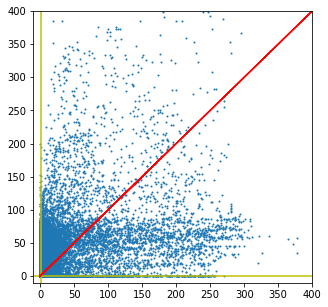

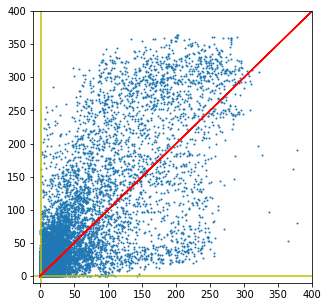

In [28]:
if year_max < 2019:
  plt.figure(1, figsize=(5,5))
  y_test_MAR = MAR['FC'][MAR.index.isin(Dataset['FC_2'][(Dataset.index.year == year_max)].index)]
  plt.plot(y_test,y_test,c='red')
  plt.scatter(y_test, y_test_MAR, s=1)
  ax = plt.gca()
  ax.set_xlim(-10,400)
  ax.set_ylim(-10,400)
  plt.hlines(1,-10,400,color='y')
  plt.vlines(1,-10,400,color='y')

  plt.figure(2, figsize=(5,5))
  plt.plot(y_test,y_test,c='red')
  plt.scatter(y_test, y_pred, s=1)
  ax = plt.gca()
  ax.set_xlim(-10,400)
  ax.set_ylim(-10,400)
  plt.hlines(1,-10,400,color='y')
  plt.vlines(1,-10,400,color='y')

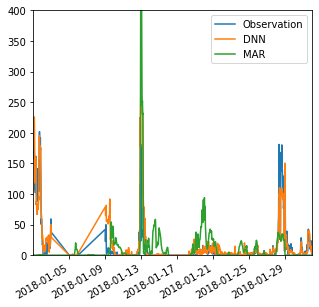

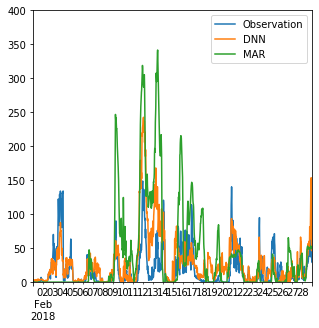

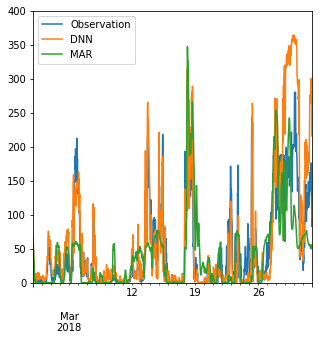

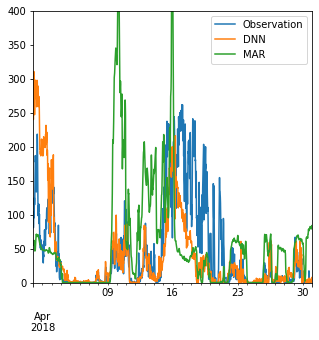

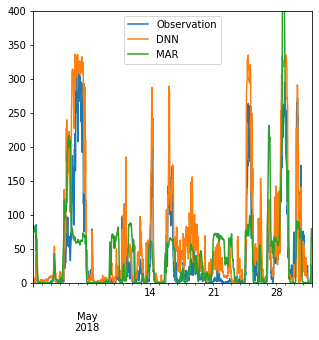

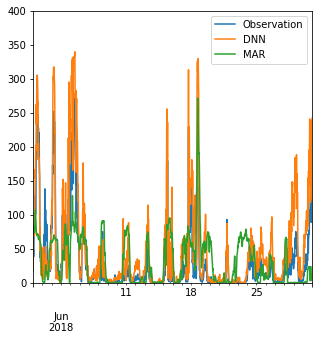

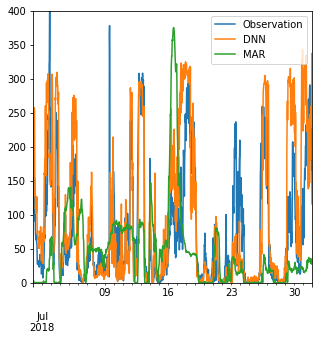

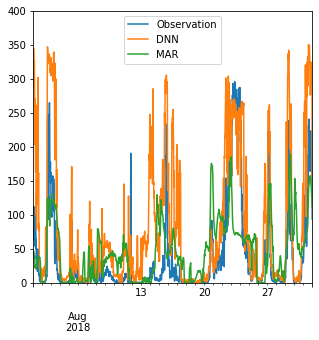

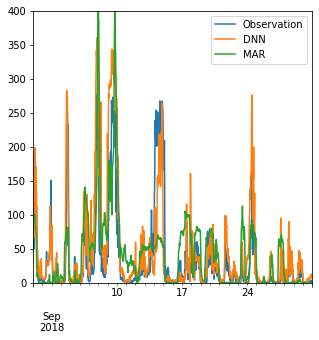

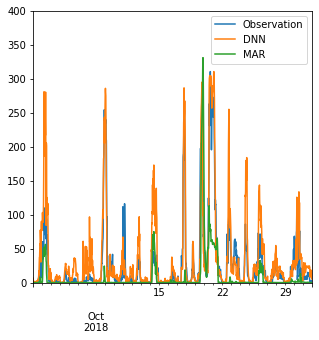

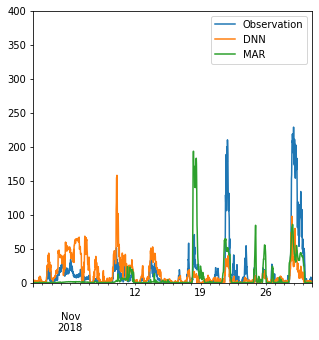

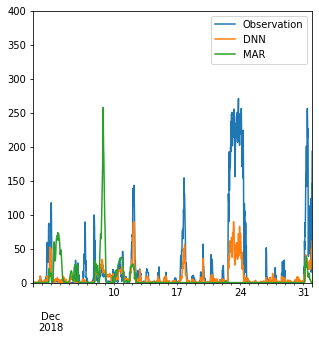

In [29]:
y_pred = pd.DataFrame(y_pred)
y_pred[y_pred<0] = 0
y_pred.index = Dataset['FC_2'][(Dataset.index.year == year_max)].index

y_test = pd.DataFrame(y_test)
y_test.index = Dataset['FC_2'][(Dataset.index.year == year_max)].index

for month in range(1,13):
    plt.figure(figsize=(5,5))
    ax = plt.gca()
    y_test[(y_test.index.month == month)].plot(ax=ax)
    y_pred[(y_pred.index.month == month)].plot(ax=ax)
    #Dataset['U2m'][(Dataset.index.year == year_max) & (Dataset.index.month == month)].plot(ax=ax)
    MAR['FC'][(MAR.index.year == year_max) & (MAR.index.month == month)].plot(ax=ax)
    ax.legend(('Observation', 'DNN', 'MAR'))
    ax.set_ylim(0,400)
    #Dataset['T2m'][(Dataset.index.year == year_max) & (Dataset.index.month == month)].plot(ax=ax)
    #Dataset['U2m'][(Dataset.index.year == year_max) & (Dataset.index.month == month)].plot(ax=ax)

In [30]:
print(y_pred.mean()-y_test.mean() - y_pred.min())
print(y_test_MAR.mean() - y_test.mean())
print(y_pred.mean())
print(y_test.mean())
print(y_test_MAR.mean())
print("\n\nCorrelation coefficient: ")
print(pd.concat([y_pred, y_test], axis=1).corr().iloc[0,1])
#print(pd.concat([Dataset['U1'][Dataset.index.year == year_max], y_test], axis=1).corr().iloc[0,1])

pd.concat([y_test_MAR, y_test], axis=1).corr().iloc[0,1]

0    11.440612
dtype: float64
0   -2.856778
dtype: float64
0    45.746002
dtype: float32
0    34.30539
dtype: float64
31.44861187887106


Correlation coefficient: 
0.7932153430800165


0.4033166813581942

# Random Forest

## Random Hyperparameter Grid

In [33]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 1500, stop = 1500, num = 1)]

# Number of features to consider at every split
max_features = ['auto']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(130, 130, num = 1)]
#max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1]

# Method of selecting samples for training each tree
bootstrap = [True]# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True],
 'max_depth': [130],
 'max_features': ['auto'],
 'min_samples_leaf': [1],
 'min_samples_split': [2],
 'n_estimators': [1500]}


In [35]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 2, verbose=10, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] n_estimators=1500, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=130, bootstrap=True 
[CV]  n_estimators=1500, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=130, bootstrap=True, score=0.931, total= 7.9min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  7.9min remaining:    0.0s


[CV] n_estimators=1500, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=130, bootstrap=True 
[CV]  n_estimators=1500, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=130, bootstrap=True, score=0.934, total= 9.6min


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 17.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 17.6min finished


RandomizedSearchCV(cv=2, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators='warn',
                                                   n_jobs=None, oob_score=False,
                                                   random_state=N

In [36]:
#best parameters from fitting the random search
rf_best_param = rf_random.best_params_
rf_best_param

{'n_estimators': 1500,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 130,
 'bootstrap': True}

## Grid Search with Cross Validation

In [37]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [rf_best_param['bootstrap']],
    'max_depth': [rf_best_param['max_depth']],
    'max_features': [rf_best_param['max_features']],
    'min_samples_leaf': [int(x) for x in np.linspace(rf_best_param['min_samples_leaf'], rf_best_param['min_samples_leaf'], num = 1)],
    'min_samples_split': [int(x) for x in np.linspace(rf_best_param['min_samples_split'], rf_best_param['min_samples_split'], num = 1)],
    'n_estimators': [int(x) for x in np.linspace(rf_best_param['n_estimators'], rf_best_param['n_estimators'], num = 1)]}
print(param_grid)

{'bootstrap': [True], 'max_depth': [130], 'max_features': ['auto'], 'min_samples_leaf': [1], 'min_samples_split': [2], 'n_estimators': [1500]}


In [38]:
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 2, n_jobs = -1, verbose = 10)
# Fit the random search model
grid_search.fit(X_train, y_train)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed: 15.2min finished
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed: 15.2min remaining:    0.0s


GridSearchCV(cv=2, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth':

## Best Random Forest model

In [39]:
best_param_rand_forest = grid_search.best_params_
best_param_rand_forest

{'bootstrap': True,
 'max_depth': 130,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 1500}

##Predicting on test value with Random Forest

In [40]:
rnd_clf = RandomForestRegressor(bootstrap = best_param_rand_forest['bootstrap'],
                                max_depth = best_param_rand_forest['max_depth'],
                                max_features = best_param_rand_forest['max_features'],
                                min_samples_leaf = best_param_rand_forest['min_samples_leaf'],
                                min_samples_split = best_param_rand_forest['min_samples_split'],
                                n_estimators = best_param_rand_forest['n_estimators'],
                                n_jobs=-1)
rnd_clf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=130,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=1500,
                      n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                      warm_start=False)

In [127]:
y_pred_rf = rnd_clf.predict(X_test)
y_pred = y_pred_rf
y_pred = pd.DataFrame(y_pred)
y_test = pd.DataFrame(y_test)
y_pred[y_pred<0] = 0

In [128]:
y_test_MAR = MAR['FC'][MAR.index.isin(Dataset['FC_2'][(Dataset.index.year == year_max)].index)]
y_pred = y_pred-y_pred.min()

print('RMSE: \n')
print(mean_squared_error(y_test, y_pred)**(0.5))
print('\nRMSE MAR: \n')
print(mean_squared_error(y_test_MAR, y_test)**(0.5))
print('\n\nBiais corrigé: ')
print(y_pred.mean()-y_test.mean() - y_pred.min())
print('\nBiais MAR: ')
print(y_test_MAR.mean() - y_test.mean())
print('\n\nMoyenne de la prédiction, référence et MAR: ')
print(y_pred.mean())
print(y_test.mean())
print(y_test_MAR.mean())
print("\n\nCorrelation coefficient: ")
print(pd.concat([y_pred, y_test], axis=1).corr().iloc[0,1])
pd.concat([y_test_MAR, y_test], axis=1).corr().iloc[0,1]

RMSE: 

39.505903190181115

RMSE MAR: 

62.41707768507205


Biais corrigé: 
0    8.105109
dtype: float64

Biais MAR: 
0   -2.856778
dtype: float64


Moyenne de la prédiction, référence et MAR: 
0    42.410499
dtype: float64
0    34.30539
dtype: float64
31.44861187887106


Correlation coefficient: 
nan


0.4033166813581942

T1 0.01808599642854266
RH1 0.011896672593412864
T4 0.01735644993180829
RH4 0.0373598284200509
U4 0.6705007019700552
rolling_mean_T1 0.045332970331822466
rolling_mean_RH1 0.03352820967041217
rolling_mean_U1 0.04688587519586175
gradient_zT4 0.0006835692466194769
vert_grad_RH 0.029671096552622594
vert_grad_T 0.012789736652025437
vert_grad_U 0.0566063515978431
rolling_sum_gradient_zT4 0.01930254140892284


([<matplotlib.axis.XTick at 0x29e22749f08>,
 <a list of 13 Text xticklabel objects>)

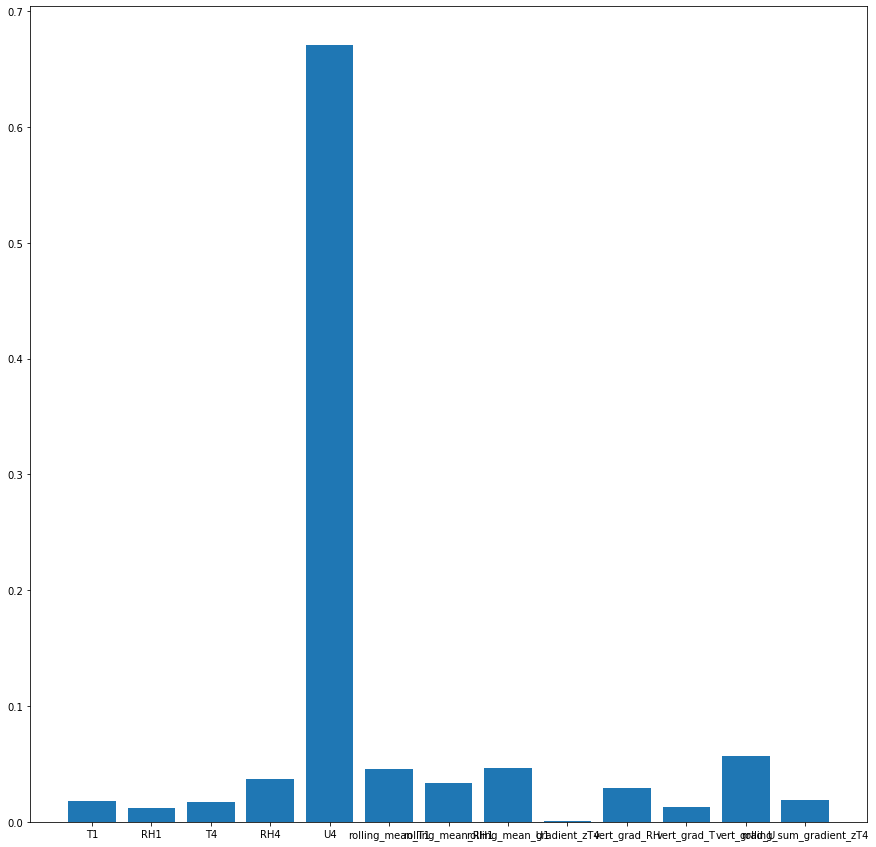

In [129]:
for name, score in zip(Dataset.columns, rnd_clf.feature_importances_):
  print(name, score)

plt.figure(figsize=(15,15))
ind = np.arange(len(rnd_clf.feature_importances_))
plt.bar(ind, rnd_clf.feature_importances_)
plt.xticks(ind, list(Dataset.columns))

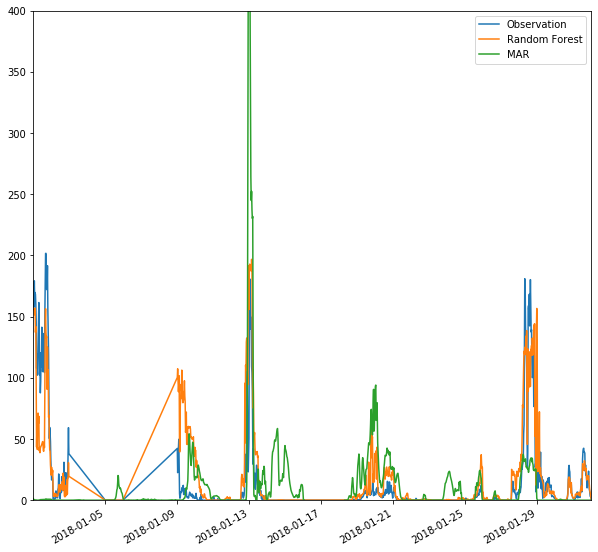

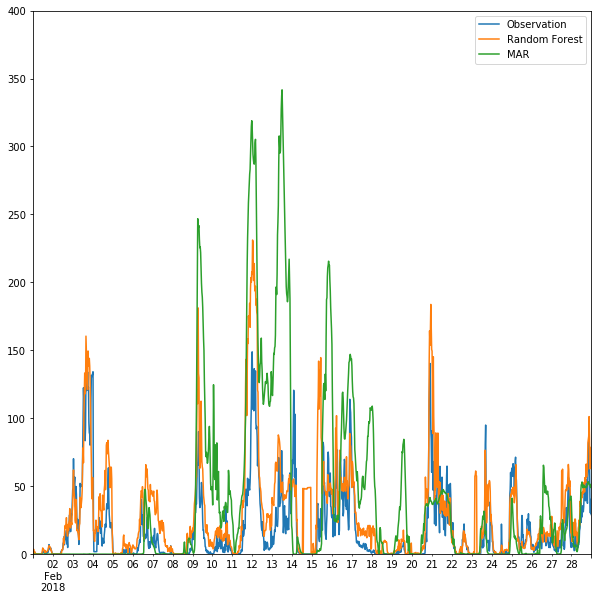

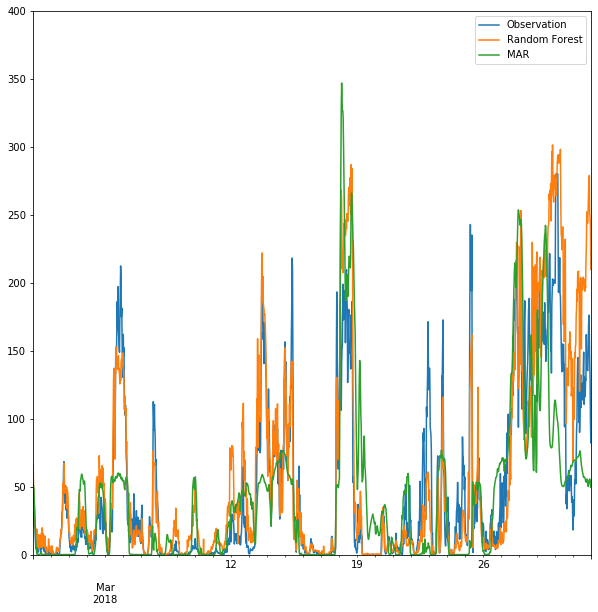

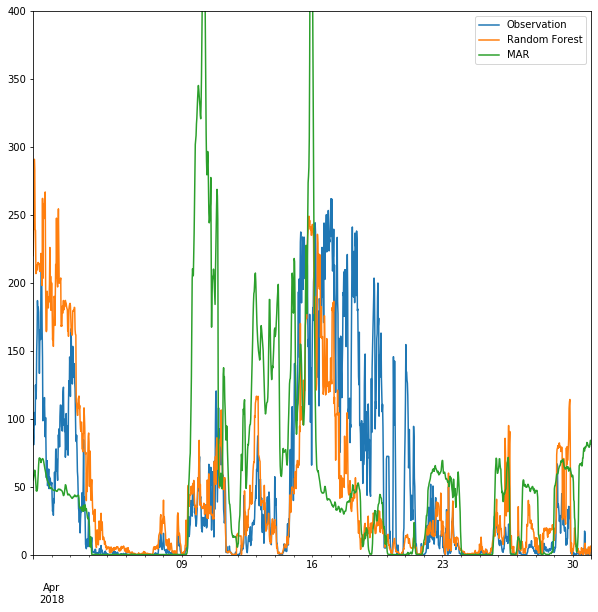

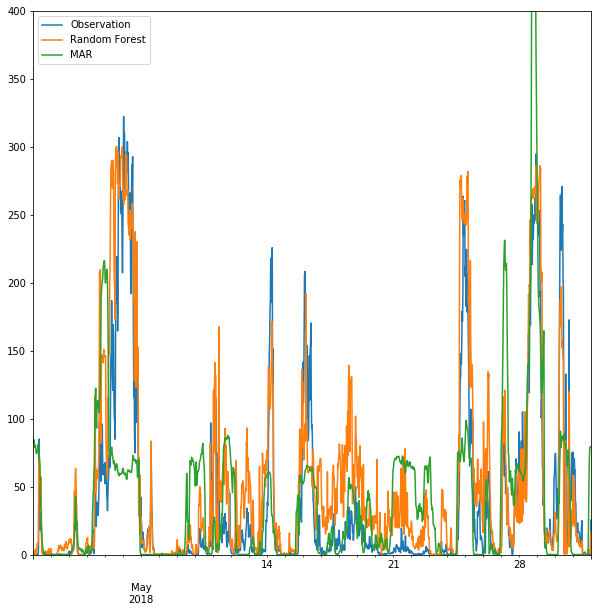

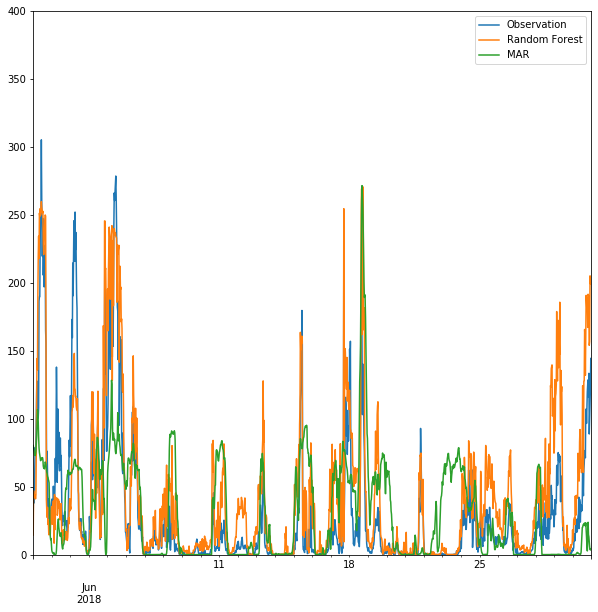

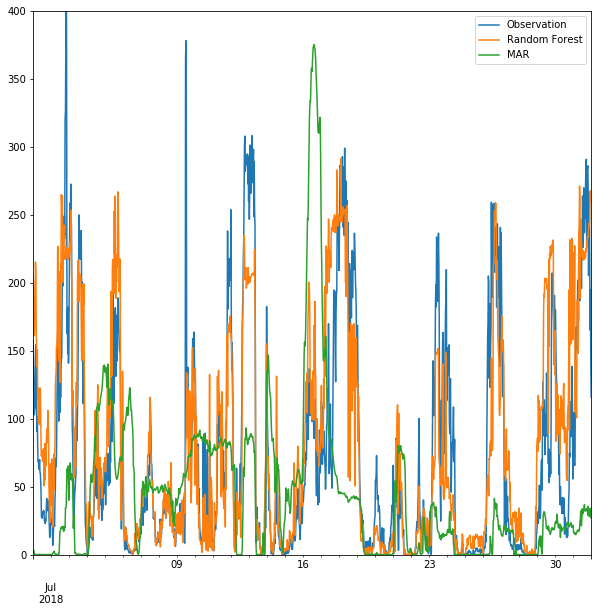

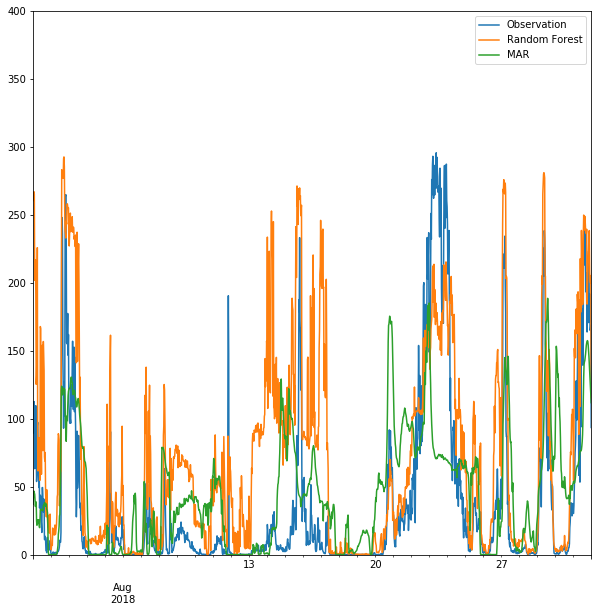

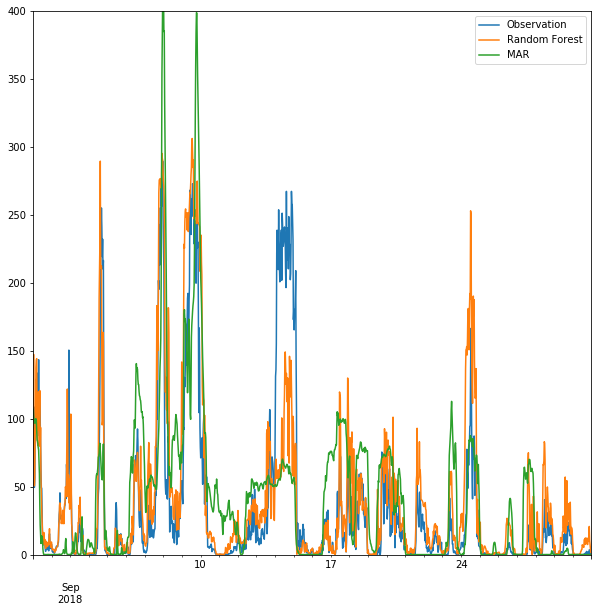

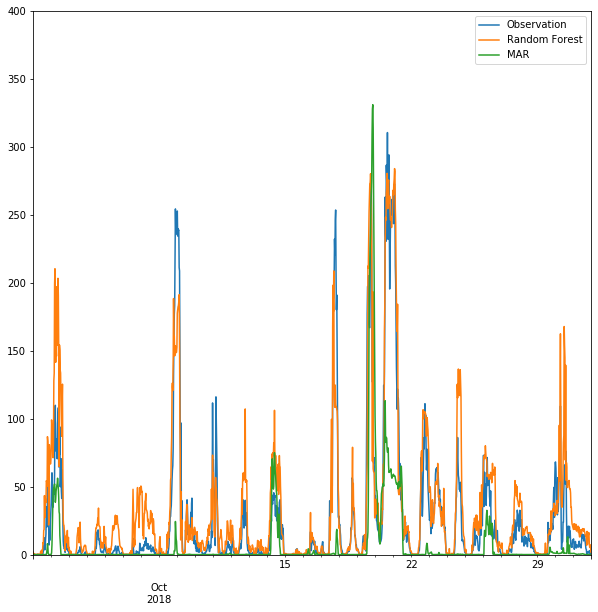

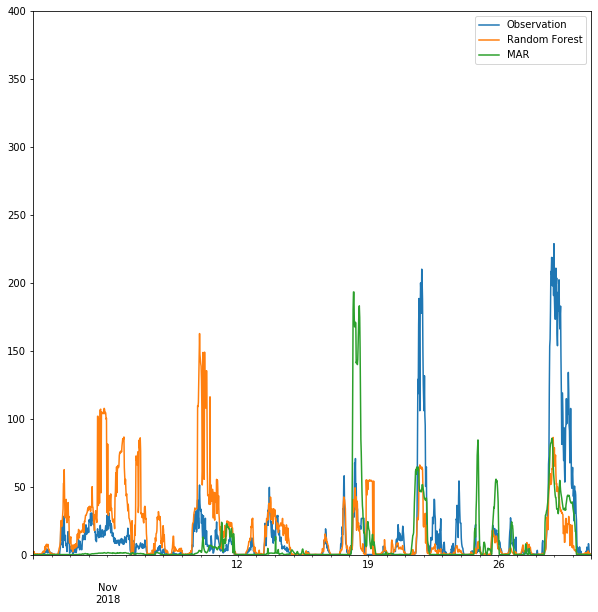

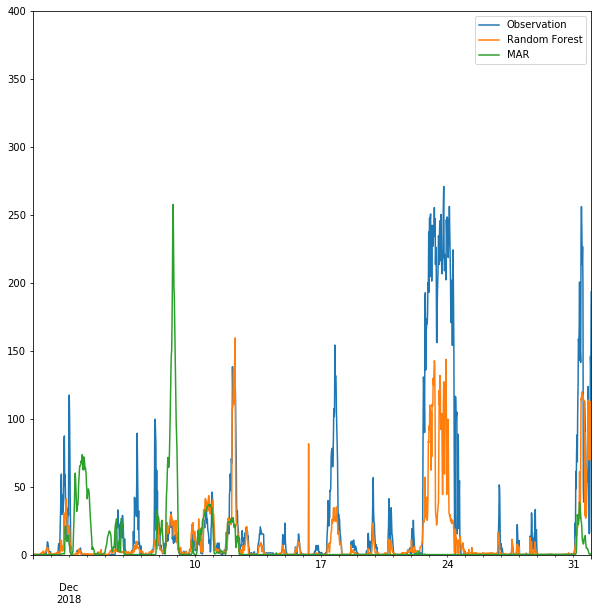

In [130]:
y_pred = pd.DataFrame(y_pred)
y_pred[y_pred<0] = 0
y_pred.index = Dataset['FC_2'][(Dataset.index.year == year_max)].index

y_test = pd.DataFrame(y_test)
y_test.index = Dataset['FC_2'][(Dataset.index.year == year_max)].index

for month in range(1,13):
    plt.figure(figsize=(10,10))
    ax = plt.gca()
    y_test[(y_test.index.month == month)].plot(ax=ax)
    y_pred[(y_pred.index.month == month)].plot(ax=ax)
    #Dataset['U2m'][(Dataset.index.year == year_max) & (Dataset.index.month == month)].plot(ax=ax)
    MAR['FC'][(MAR.index.year == year_max) & (MAR.index.month == month)].plot(ax=ax)
    ax.legend(('Observation', 'Random Forest', 'MAR'))
    ax.set_ylim(0,400)
    #Dataset['T2m'][(Dataset.index.year == year_max) & (Dataset.index.month == month)].plot(ax=ax)
    #Dataset['U2m'][(Dataset.index.year == year_max) & (Dataset.index.month == month)].plot(ax=ax)

# Lasso Regression


In [45]:
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha=0.3)
lasso_reg.fit(X_train, y_train)
y_pred = lasso_reg.predict(X_test)

In [46]:
from sklearn.metrics import mean_squared_error
y_test_MAR = MAR['FC'][MAR.index.isin(Dataset['FC_2'][(Dataset.index.year == year_max)].index)]
y_pred = pd.DataFrame(y_pred)
y_pred[y_pred<0] = 0
print('RMSE: \n')
print(mean_squared_error(y_test, y_pred)**(0.5))
print('Biais corrigé: ')
print(y_pred.mean()-y_test.mean() - y_pred.min())
print('\nBiais MAR: ')
print(y_test_MAR.mean() - y_test.mean())
print('\n\nMoyenne de la prédiction, référence et MAR: ')
print(y_pred.mean())
print(y_test.mean())
print(y_test_MAR.mean())
print("\n\nCorrelation coefficient: ")
print(pd.concat([y_pred, y_test], axis=1).corr().iloc[0,1])
pd.concat([y_test_MAR, y_test], axis=1).corr().iloc[0,1]

RMSE: 

38.221474961471245
Biais corrigé: 
0    8.419714
dtype: float64

Biais MAR: 
0   -2.856778
dtype: float64


Moyenne de la prédiction, référence et MAR: 
0    42.725104
dtype: float64
0    34.30539
dtype: float64
31.44861187887106


Correlation coefficient: 
nan


0.4033166813581942

([<matplotlib.axis.XTick at 0x29e1db4fc48>,
 <a list of 13 Text xticklabel objects>)

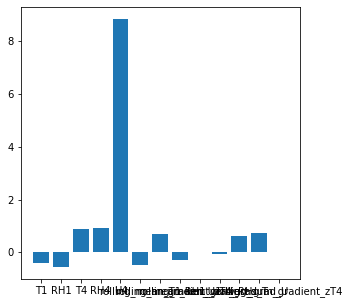

In [47]:
plt.figure(figsize=(5,5))
ind = np.arange(len(lasso_reg.coef_))
plt.bar(ind, lasso_reg.coef_)
plt.xticks(ind, list(Dataset.columns))

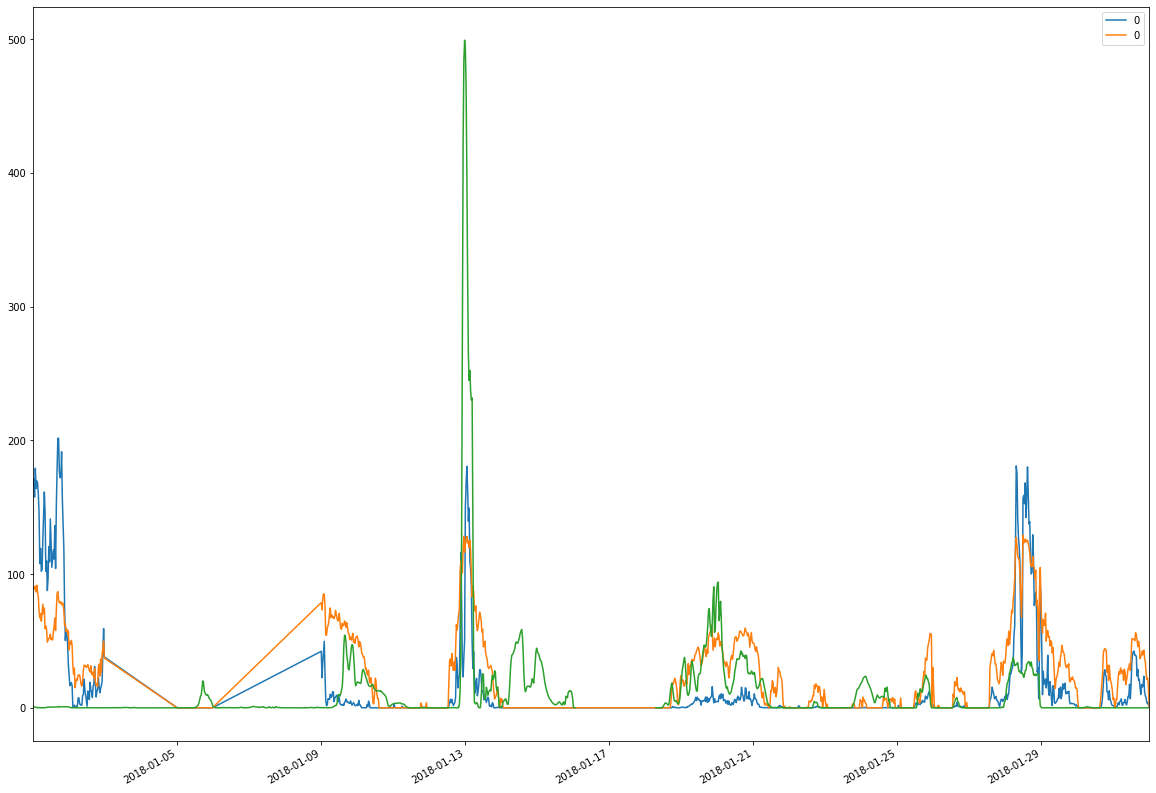

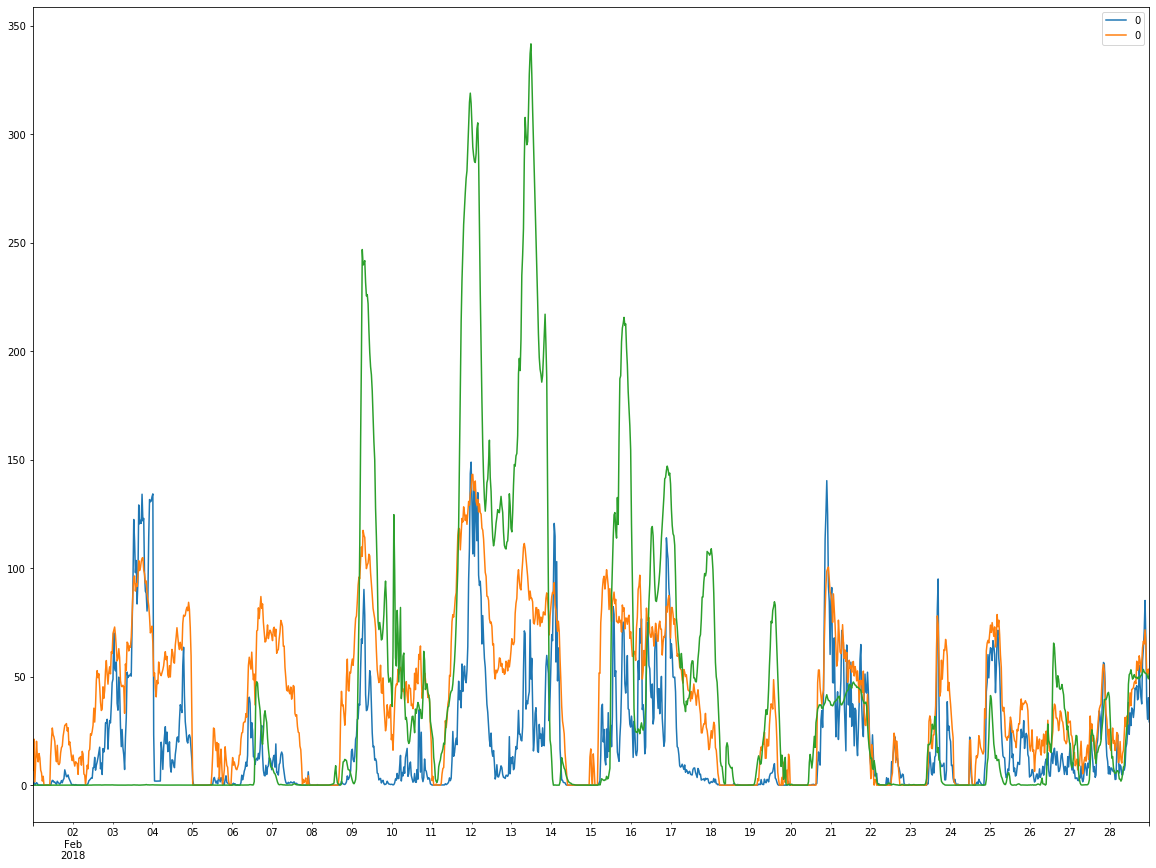

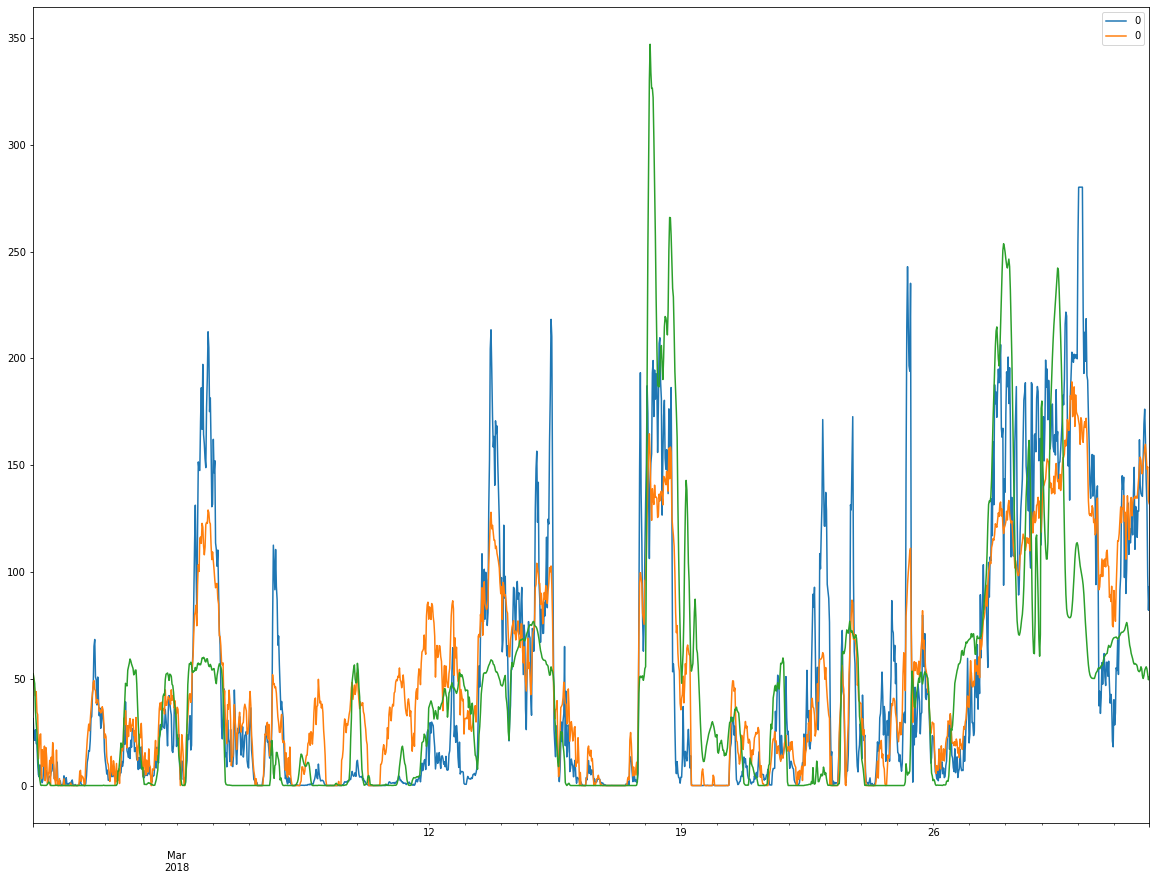

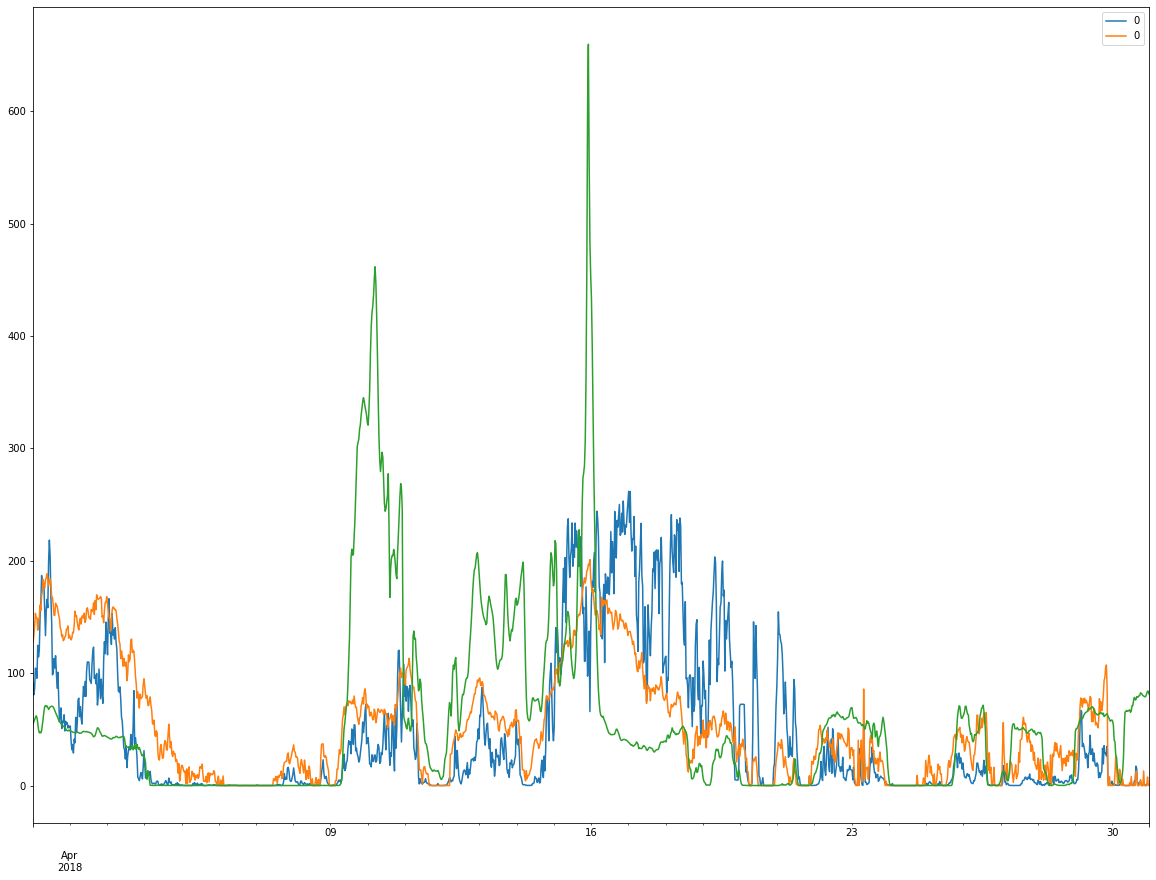

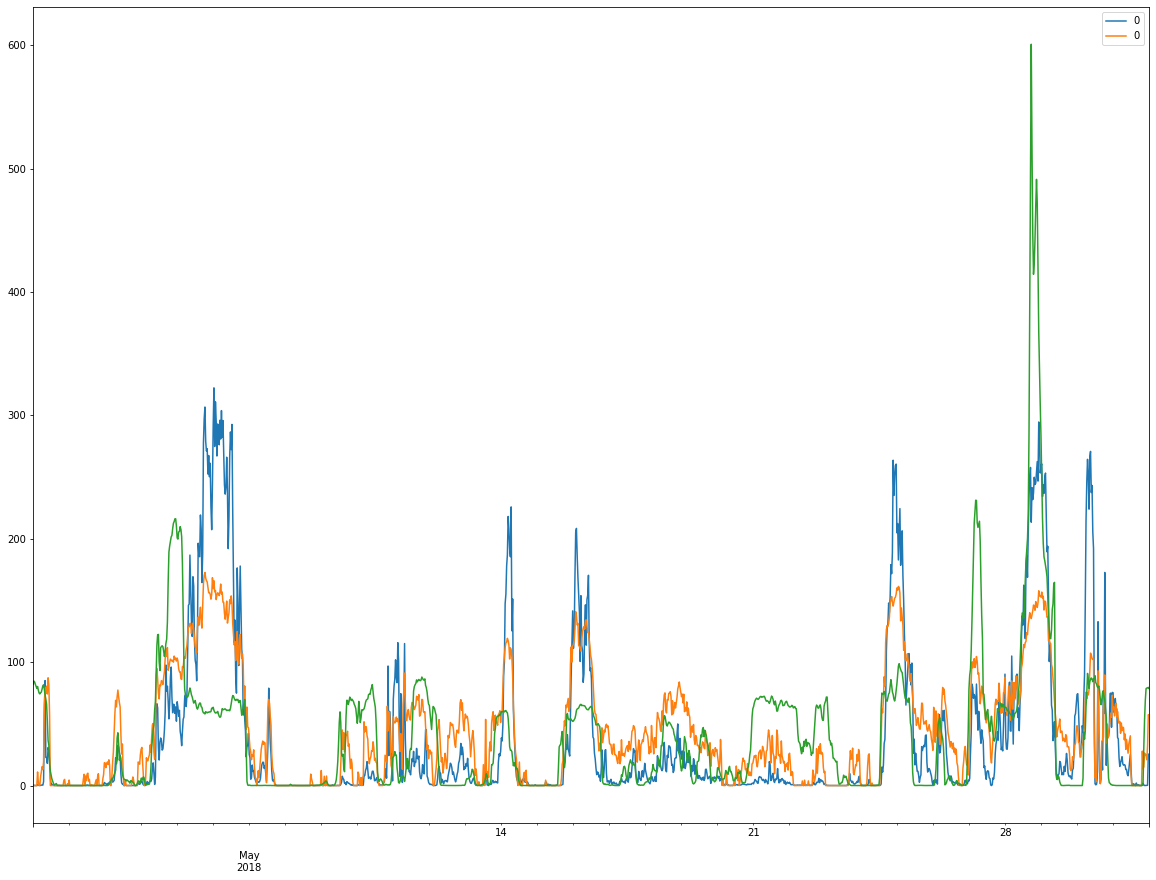

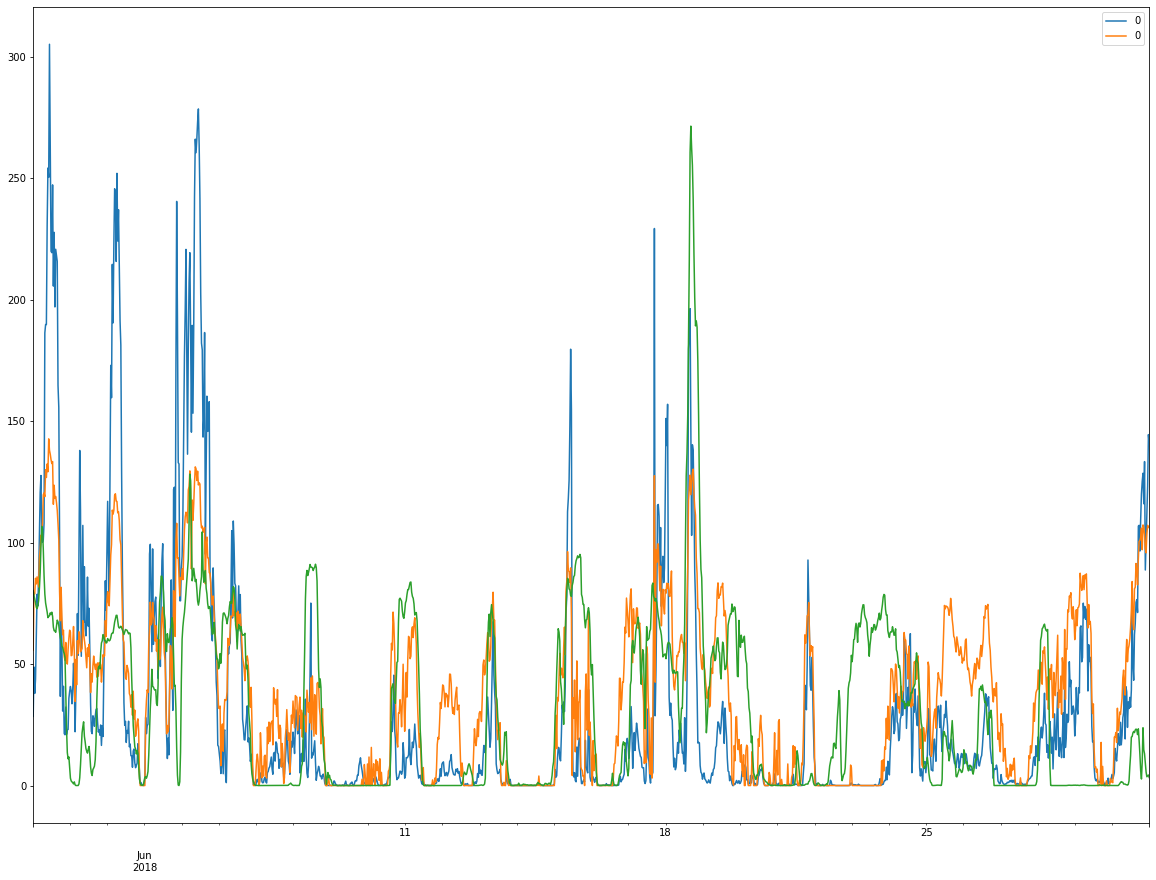

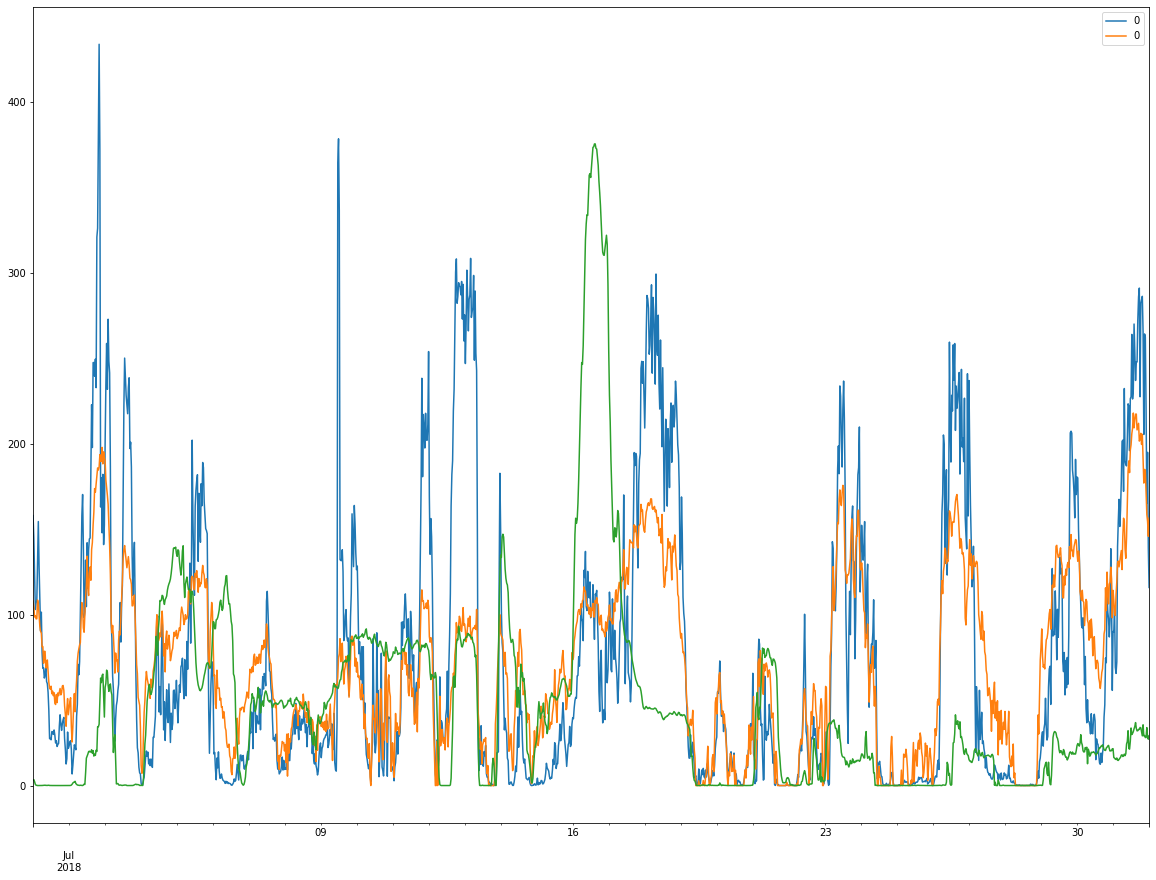

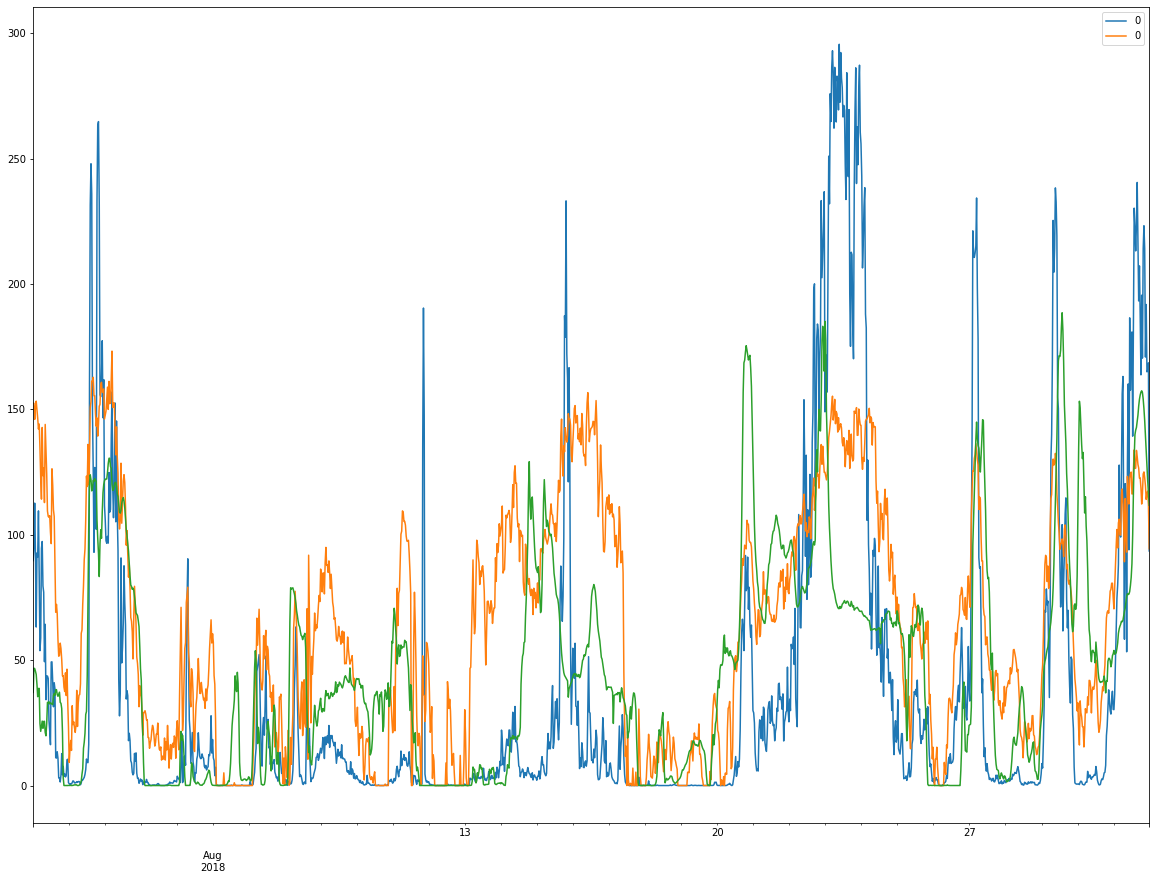

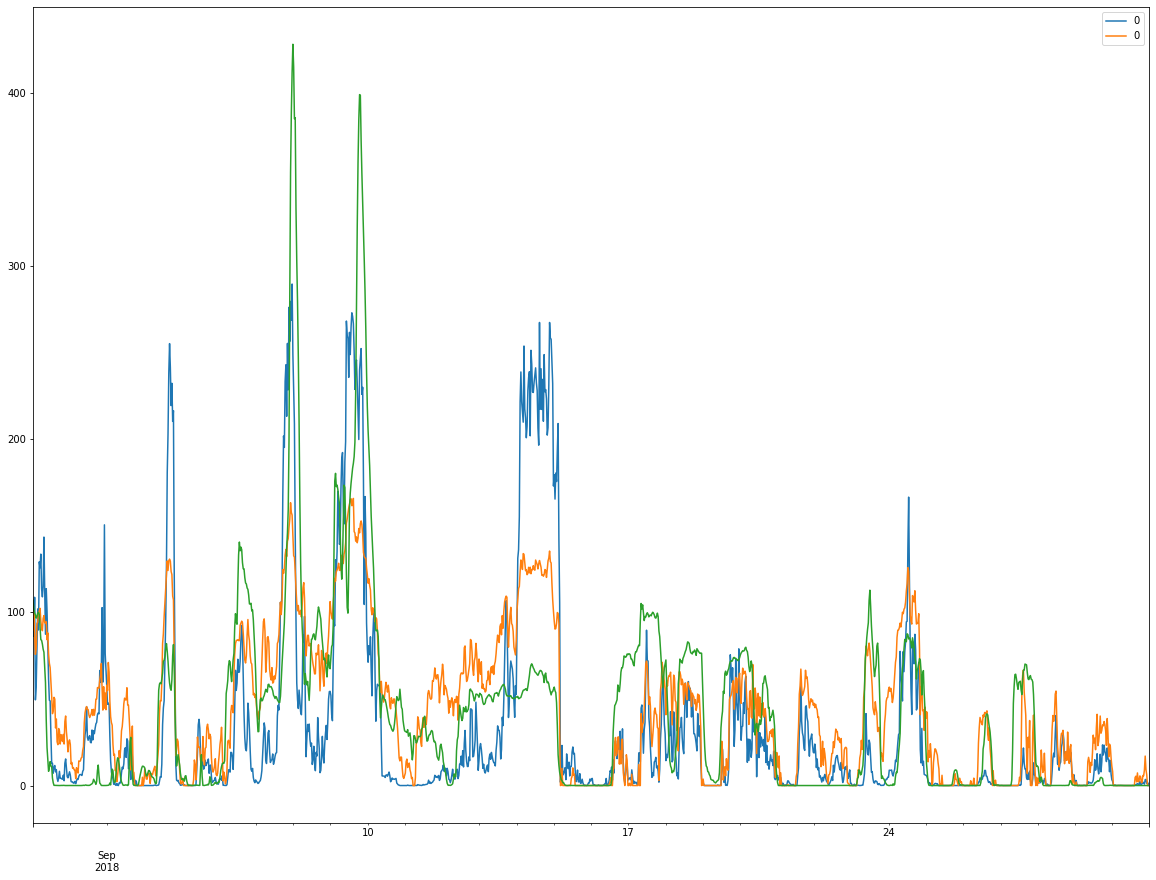

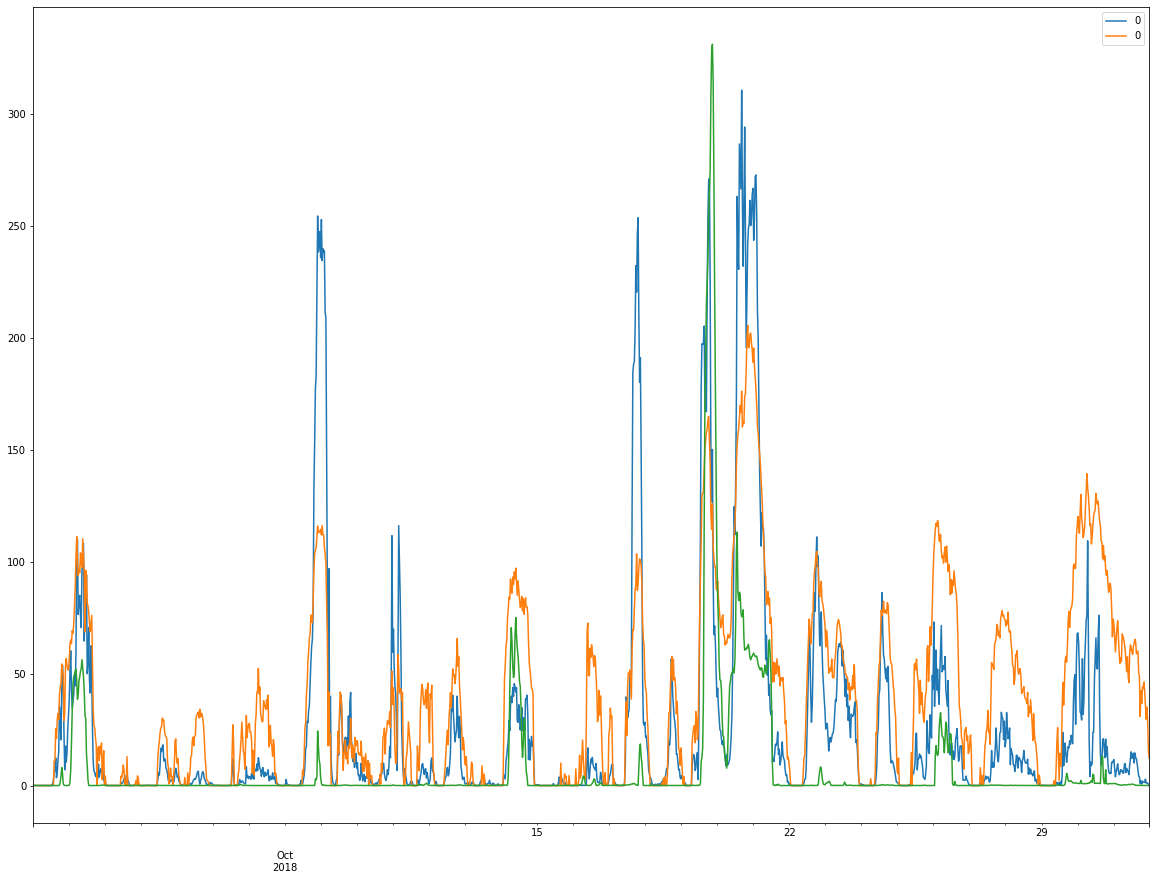

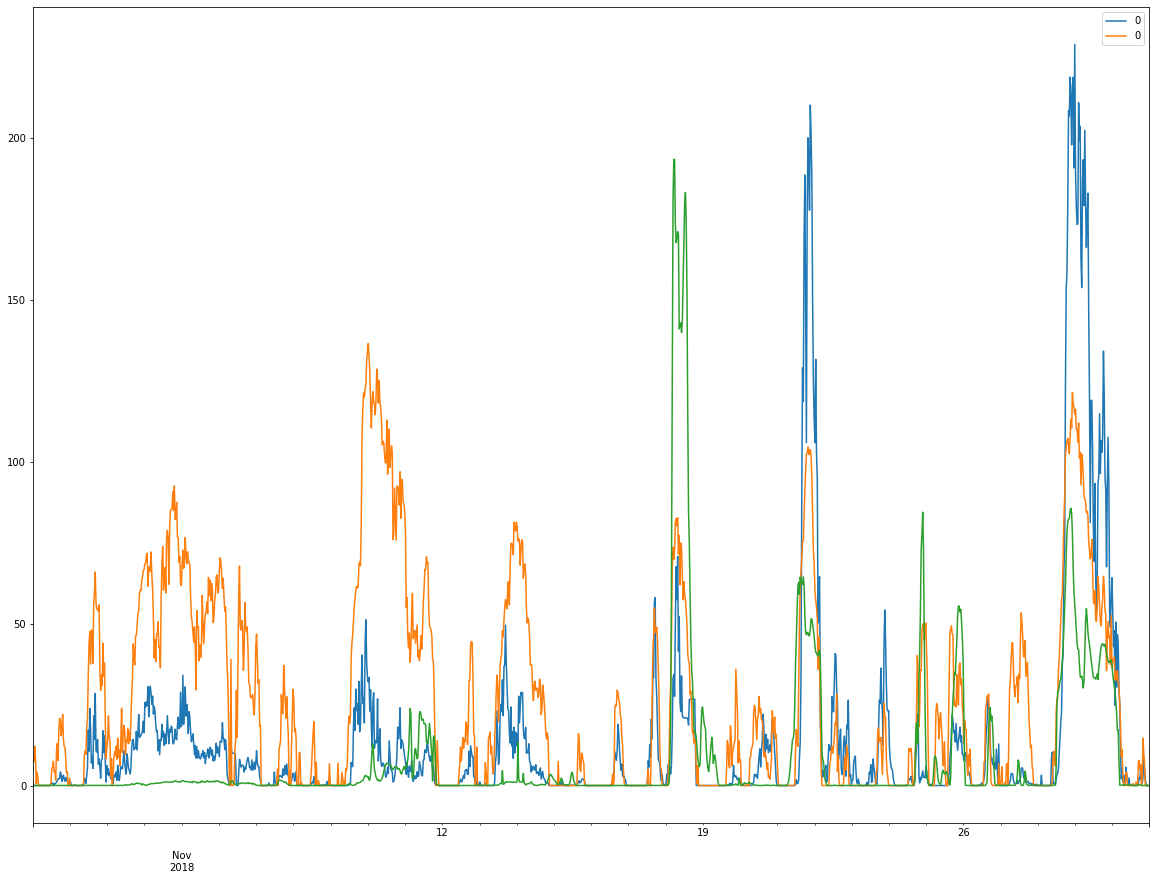

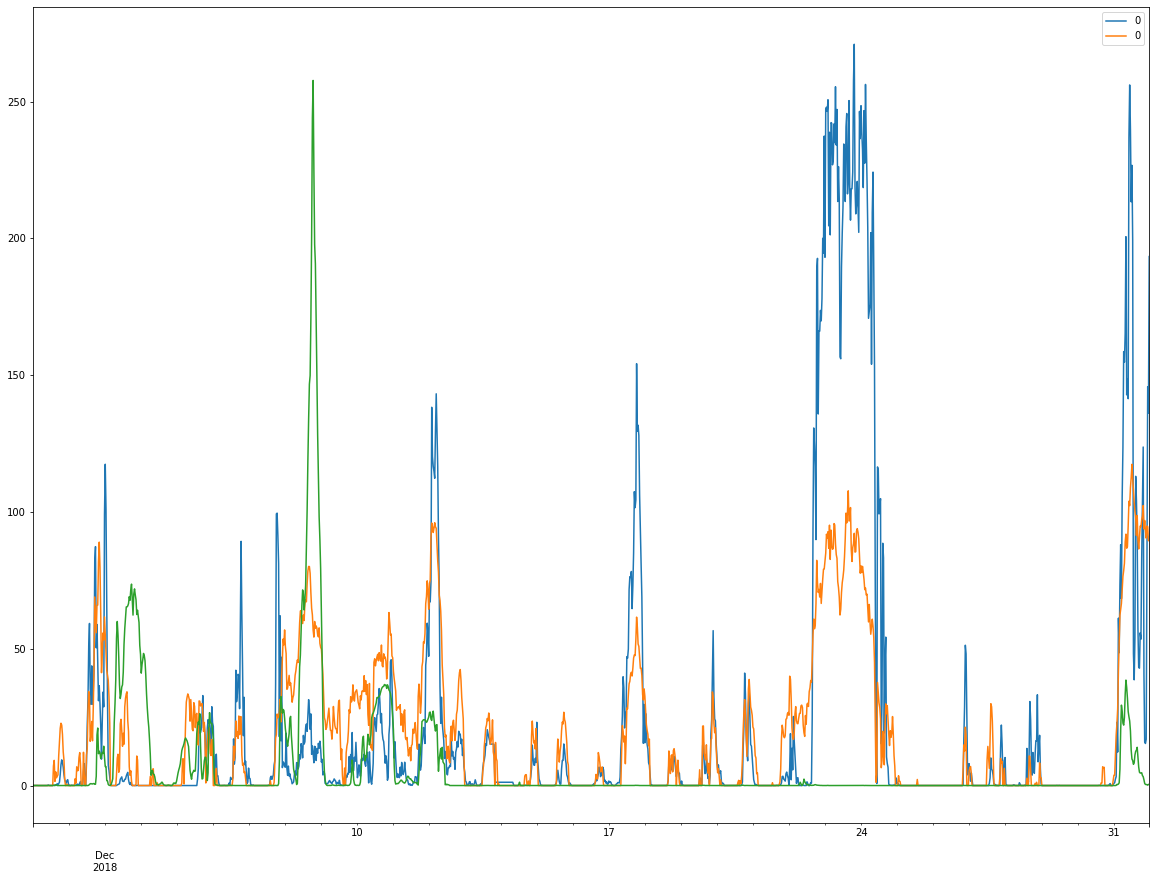

In [48]:
y_pred = pd.DataFrame(y_pred)
y_pred[y_pred<0] = 0
y_pred.index = Dataset['FC_2'][(Dataset.index.year == year_max)].index

y_test = pd.DataFrame(y_test)
y_test.index = Dataset['FC_2'][(Dataset.index.year == year_max)].index

for month in range(1,13):
    plt.figure(figsize=(5,5))
    ax = plt.gca()
    y_test[(y_test.index.month == month)].plot(ax=ax, figsize=(20,15))
    y_pred[(y_pred.index.month == month)].plot(ax=ax)
    #Dataset['U2m'][(Dataset.index.year == year_max) & (Dataset.index.month == month)].plot(ax=ax)
    MAR['FC'][(MAR.index.year == year_max) & (MAR.index.month == month)].plot(ax=ax)
    #Dataset['T2m'][(Dataset.index.year == year_max) & (Dataset.index.month == month)].plot(ax=ax)
    #Dataset['U2m'][(Dataset.index.year == year_max) & (Dataset.index.month == month)].plot(ax=ax)

# Polynomial regression

In [49]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False) 
X_poly = poly_features.fit_transform(X_train)

In [50]:
#from sklearn.linear_model import LinearRegression
#lin_reg = LinearRegression() 
#lin_reg.fit(X_poly, y_train)
poly_reg = Lasso(alpha=0.3)
poly_reg.fit(X_poly, y_train)

Lasso(alpha=0.3, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [51]:
X_test_poly = poly_features.fit_transform(X_test)
#y_pred = lin_reg.predict(X_test_poly)

y_pred = poly_reg.predict(X_test_poly)

In [52]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, y_pred)**(0.5)

36.04794494304372

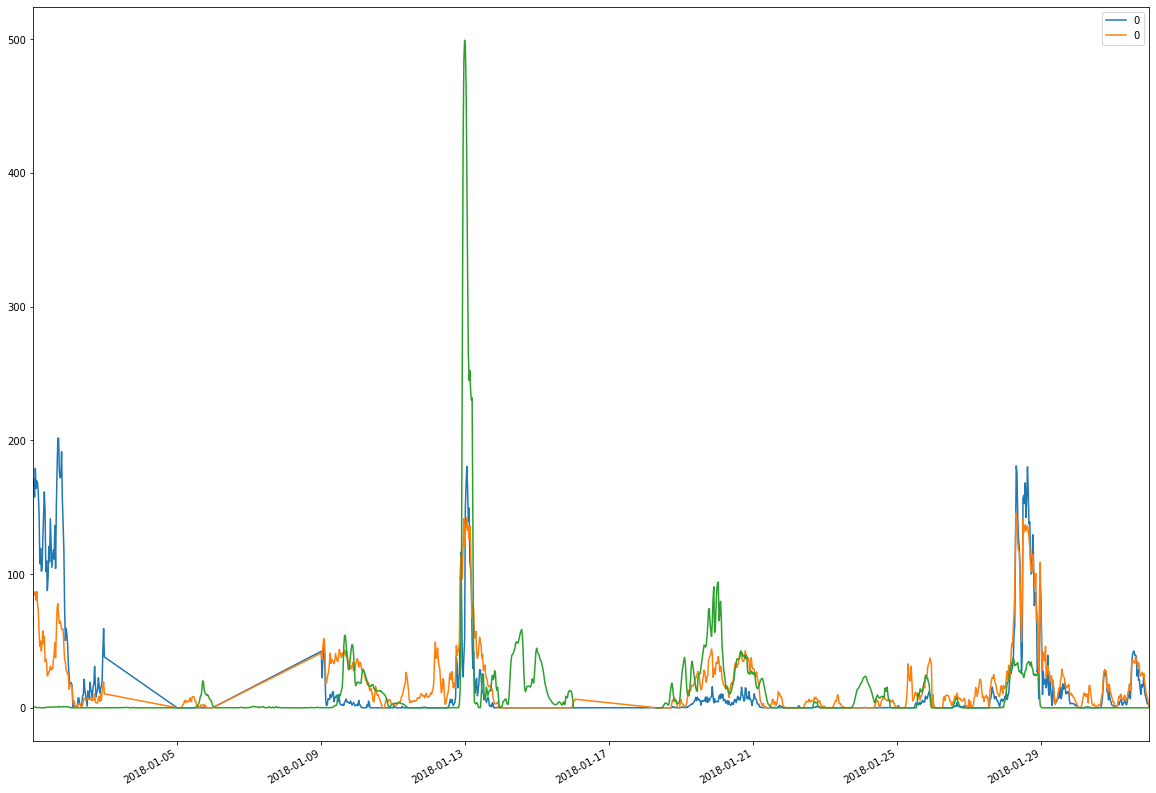

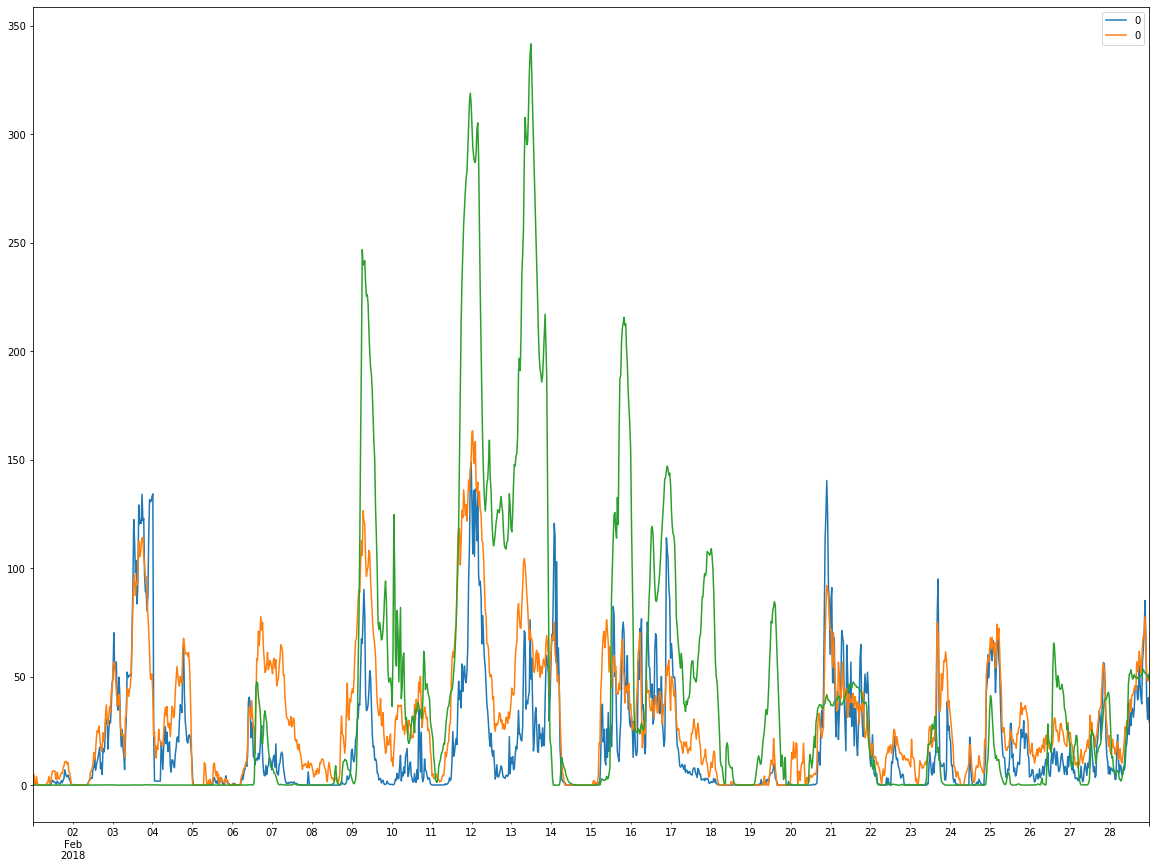

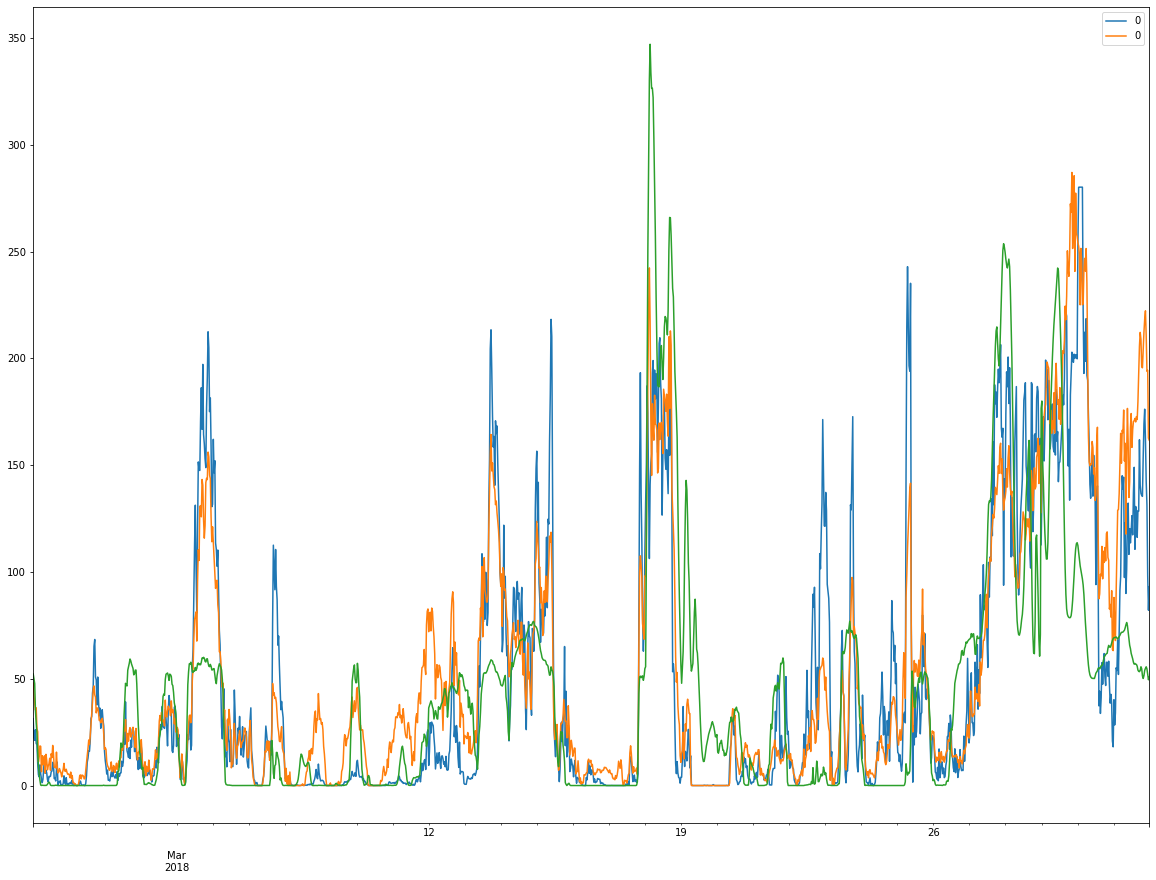

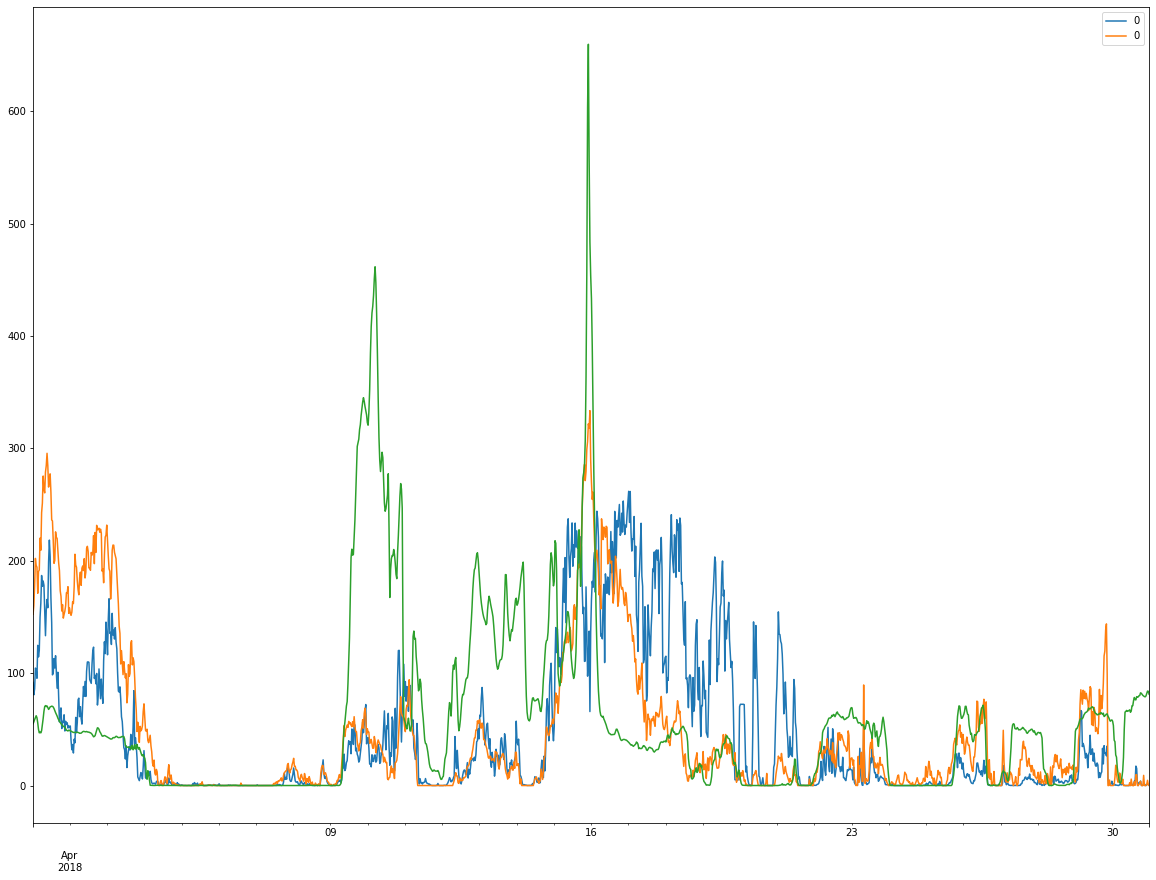

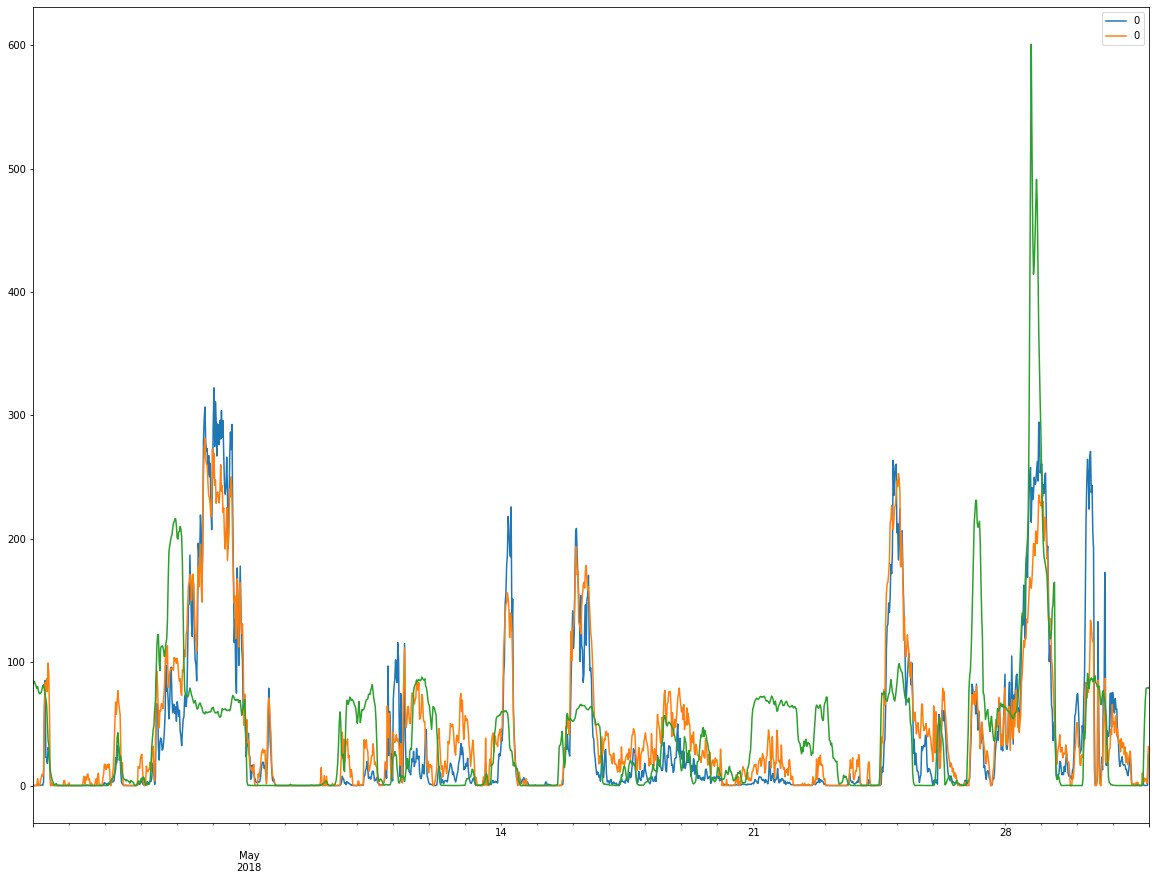

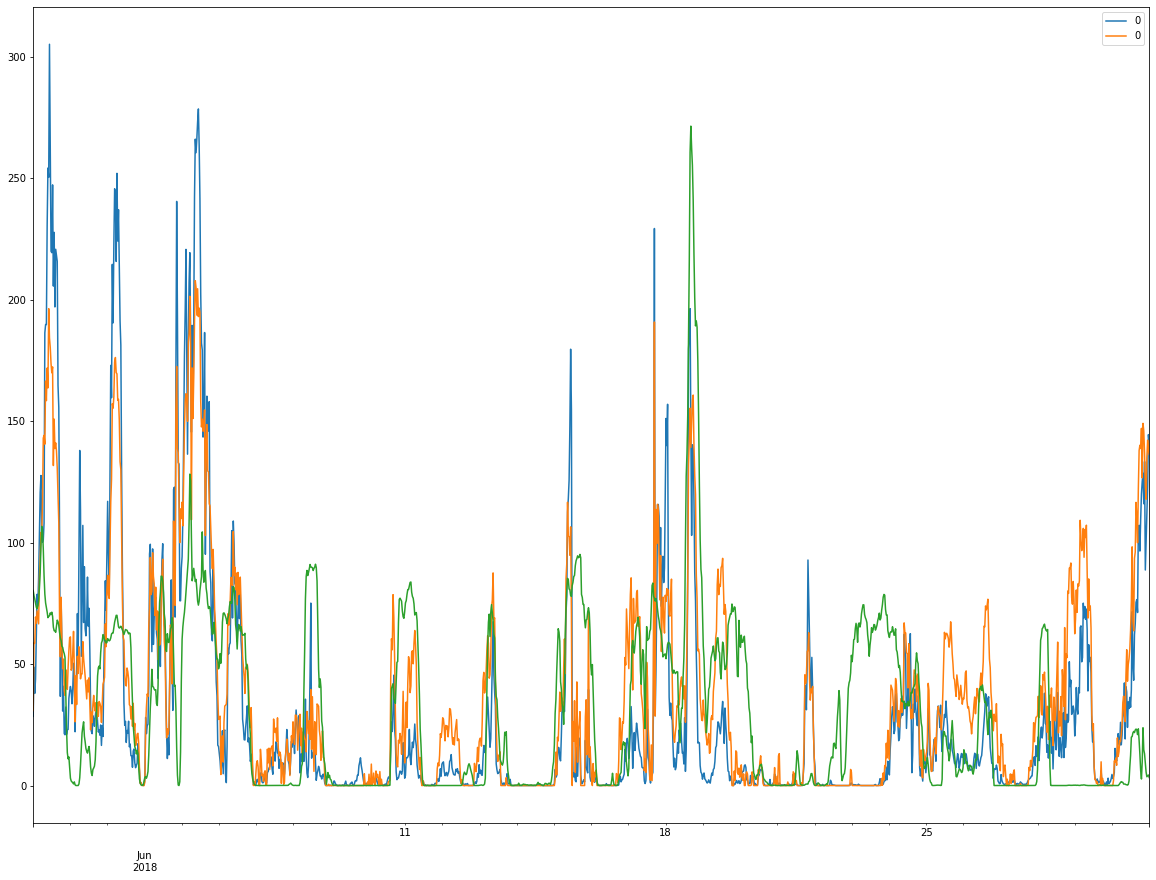

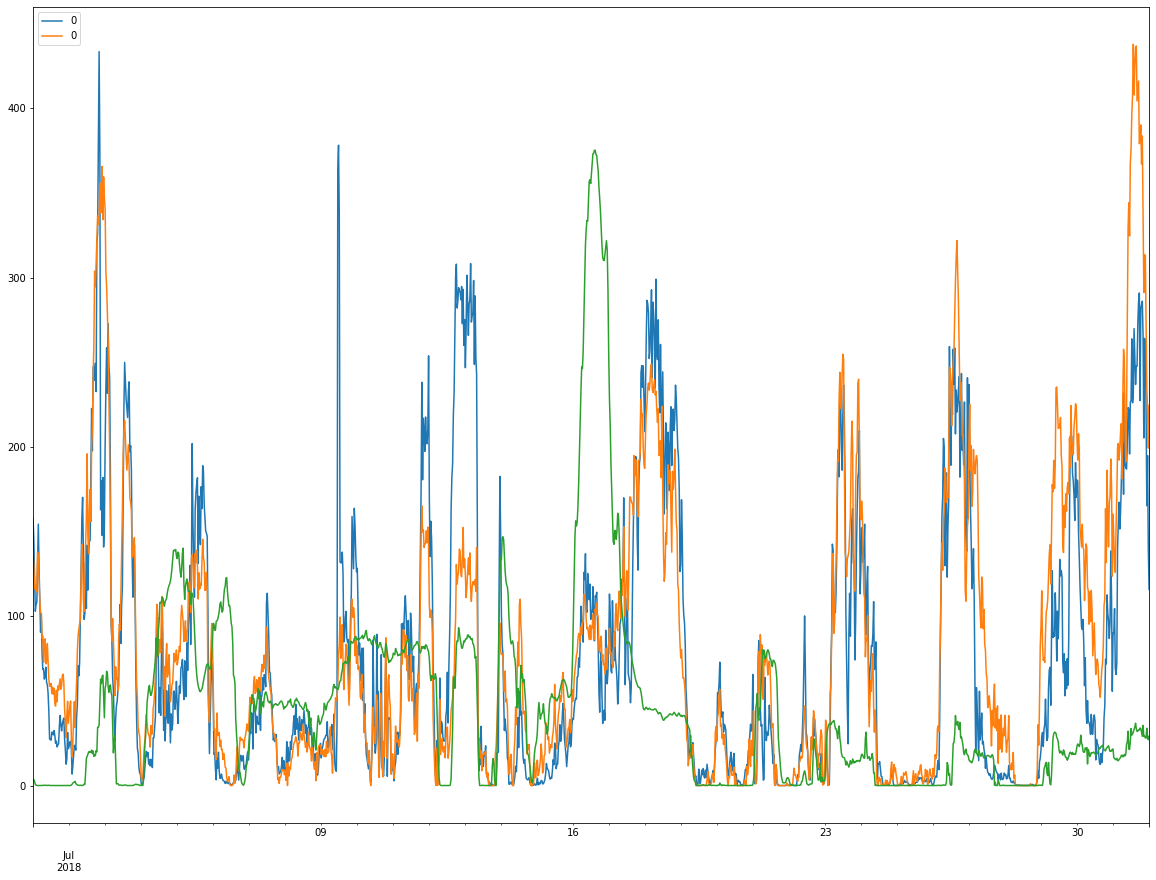

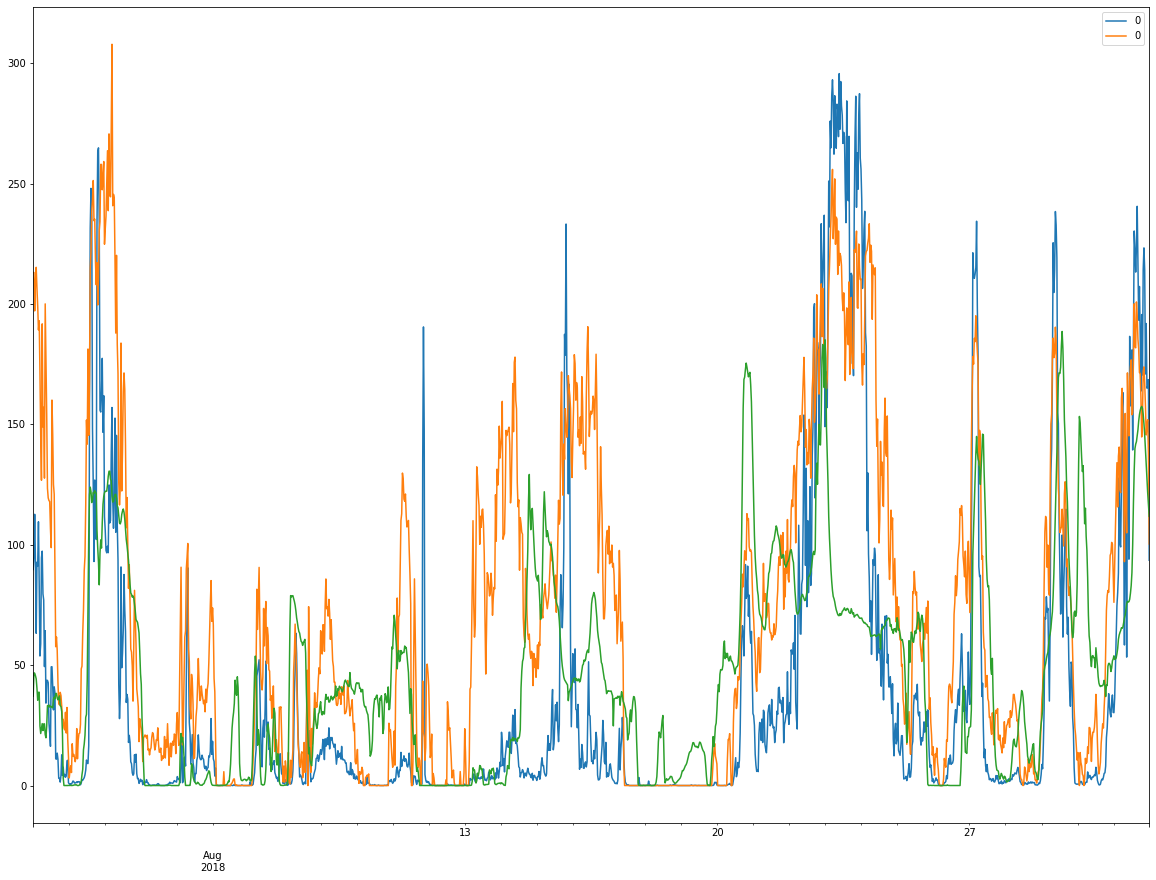

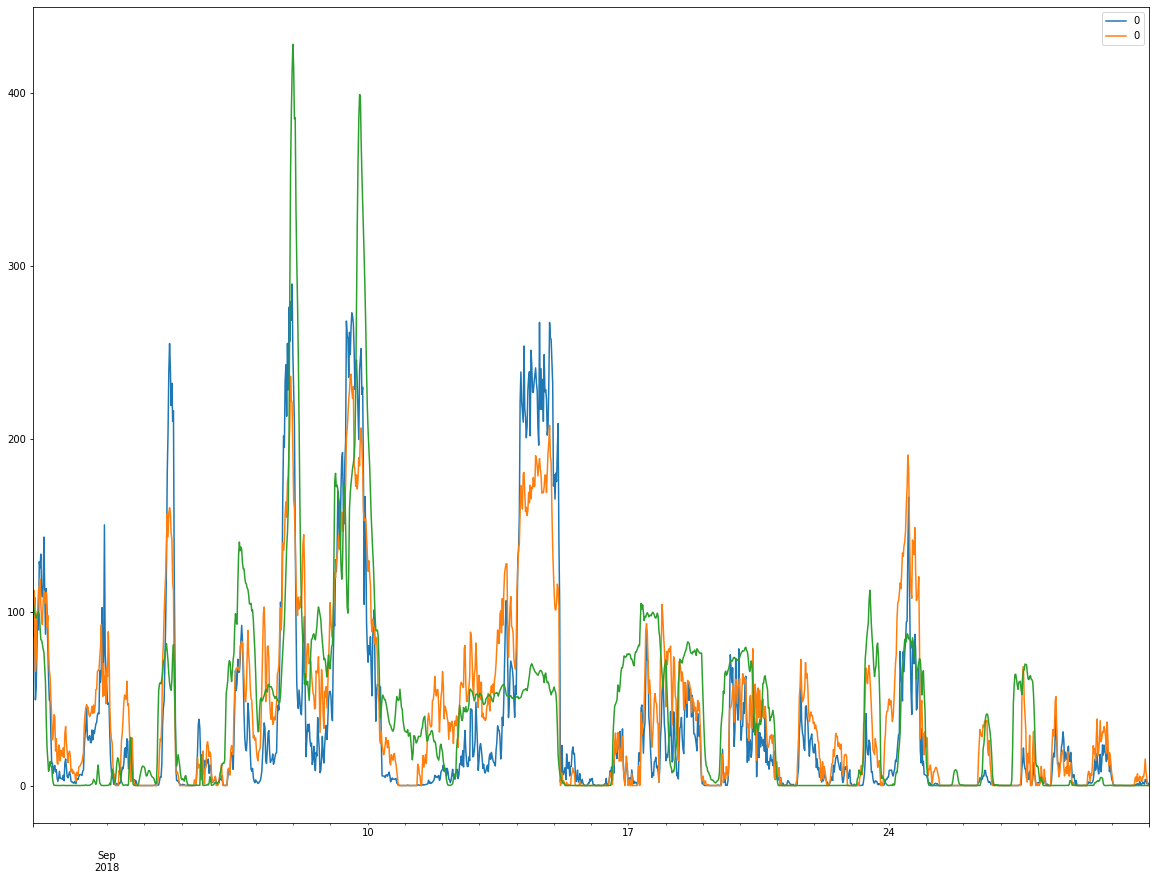

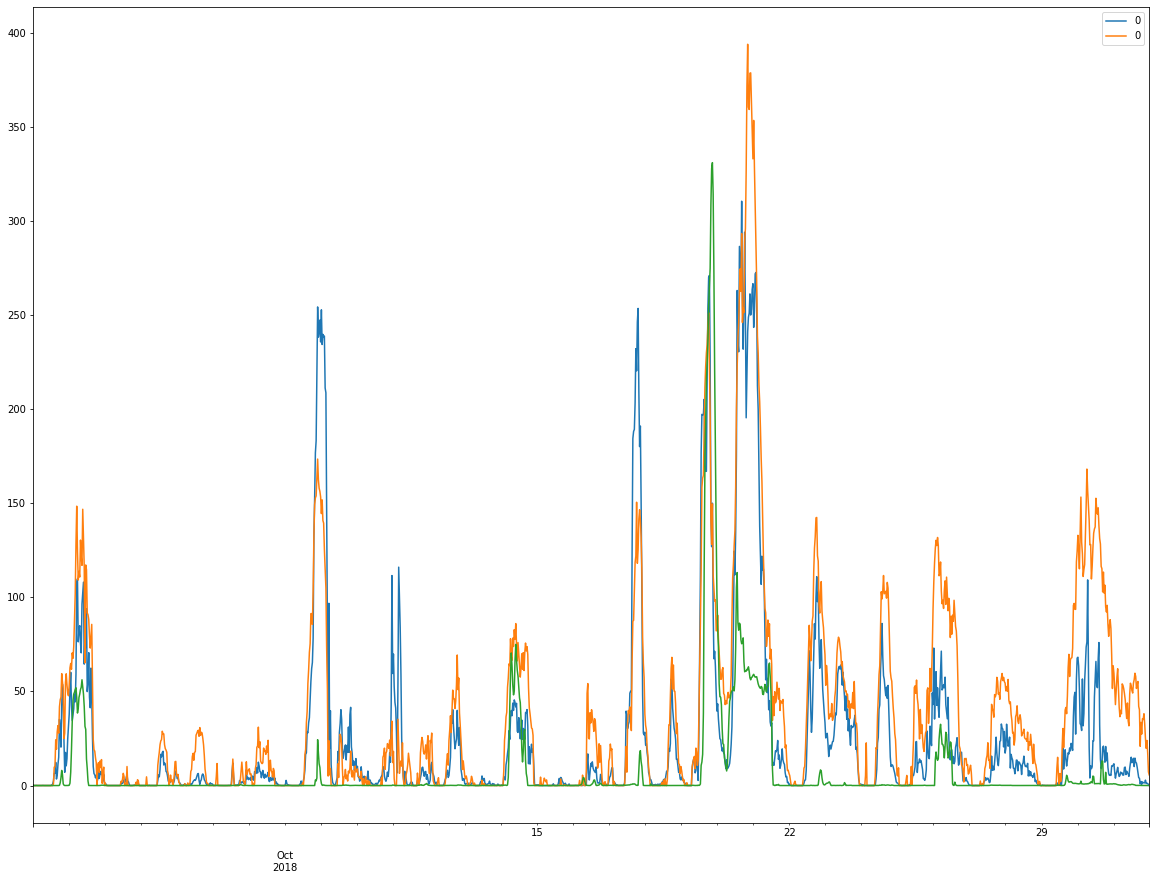

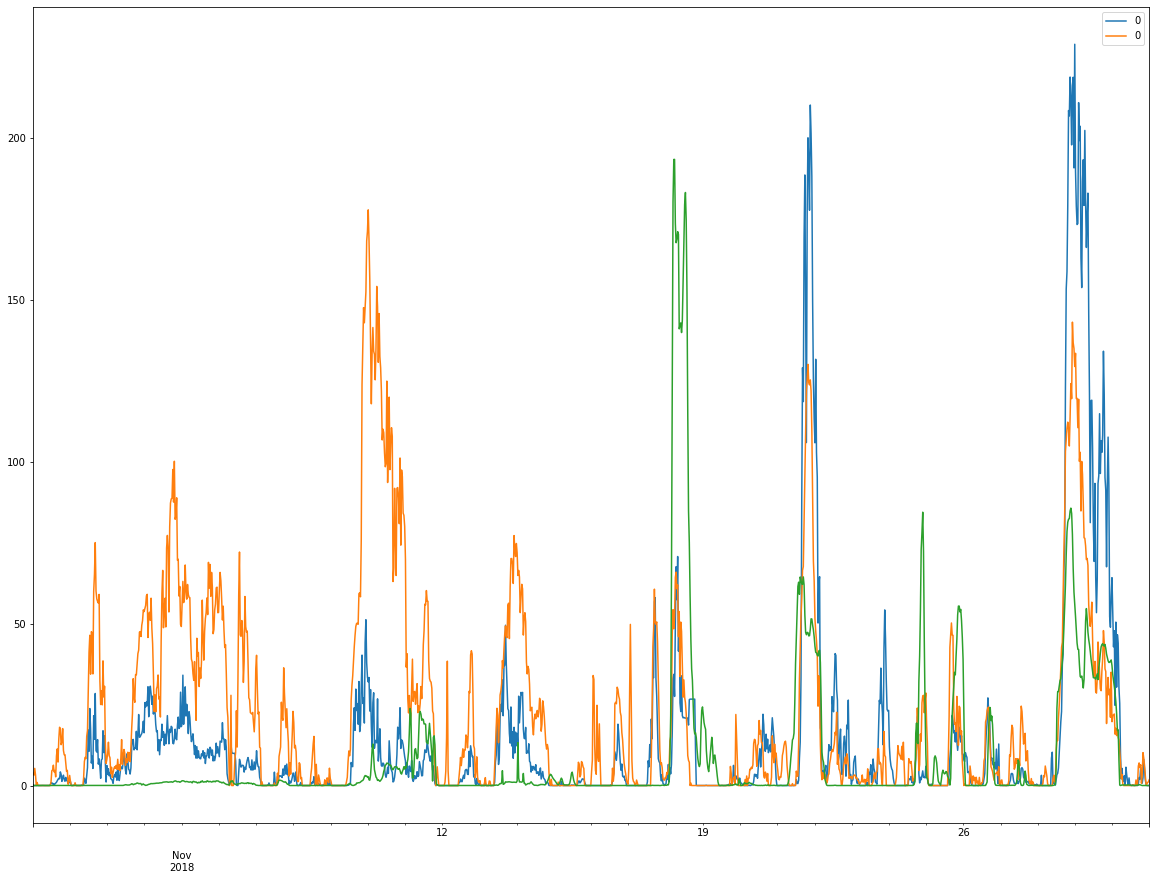

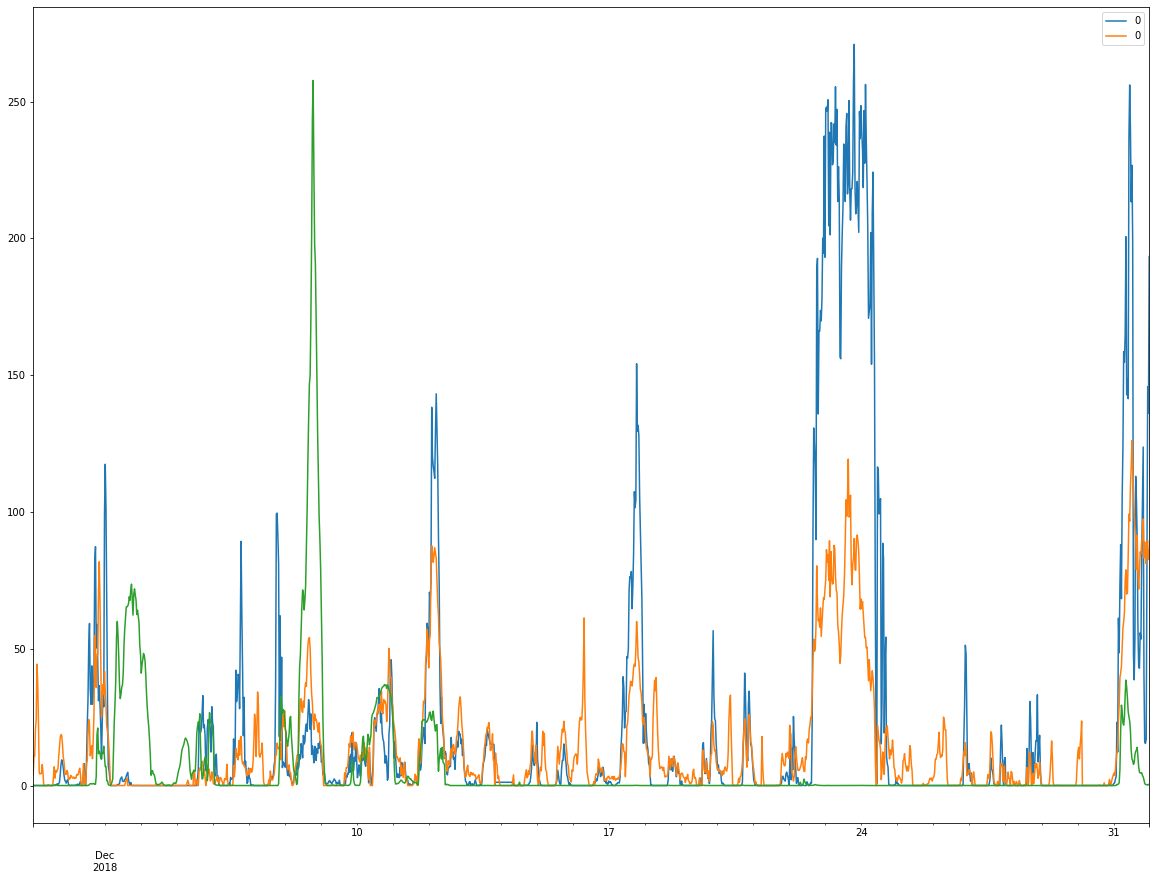

In [53]:
y_pred = pd.DataFrame(y_pred)
y_pred[y_pred<0] = 0
y_pred.index = Dataset['FC_2'][(Dataset.index.year == year_max)].index

y_test = pd.DataFrame(y_test)
y_test.index = Dataset['FC_2'][(Dataset.index.year == year_max)].index

for month in range(1,13):
    plt.figure()
    ax = plt.gca()
    y_test[(y_test.index.month == month)].plot(ax=ax, figsize=(20,15))
    y_pred[(y_pred.index.month == month)].plot(ax=ax)
    #Dataset['U2m'][(Dataset.index.year == year_max) & (Dataset.index.month == month)].plot(ax=ax)
    MAR['FC'][(MAR.index.year == year_max) & (MAR.index.month == month)].plot(ax=ax)
    #Dataset['T2m'][(Dataset.index.year == year_max) & (Dataset.index.month == month)].plot(ax=ax)
    #Dataset['U2m'][(Dataset.index.year == year_max) & (Dataset.index.month == month)].plot(ax=ax)

# SVM

In [54]:
#from sklearn.svm import SVR
#svm_poly_reg = SVR(kernel="poly", degree=2, C=100, epsilon=0.1)
#svm_poly_reg.fit(X_train, y_train)

In [55]:
#y_pred = svm_poly_reg.predict(X_test)

In [56]:
#from sklearn.metrics import mean_squared_error
#mean_squared_error(y_test, y_pred)**(0.5)

In [57]:
'''
y_pred = pd.DataFrame(y_pred)
y_pred[y_pred<0] = 0
y_pred.index = Dataset['FC_2'][(Dataset.index.year == year_max)].index

y_test = pd.DataFrame(y_test)
y_test.index = Dataset['FC_2'][(Dataset.index.year == year_max)].index

for month in range(1,13):
    plt.figure()
    ax = plt.gca()
    y_test[(y_test.index.month == month)].plot(ax=ax, figsize=(20,15))
    y_pred[(y_pred.index.month == month)].plot(ax=ax)
    #Dataset['U2m'][(Dataset.index.year == year_max) & (Dataset.index.month == month)].plot(ax=ax)
    MAR['FC'][(MAR.index.year == year_max) & (MAR.index.month == month)].plot(ax=ax)
    #Dataset['T2m'][(Dataset.index.year == year_max) & (Dataset.index.month == month)].plot(ax=ax)
    #Dataset['U2m'][(Dataset.index.year == year_max) & (Dataset.index.month == month)].plot(ax=ax)
'''

"\ny_pred = pd.DataFrame(y_pred)\ny_pred[y_pred<0] = 0\ny_pred.index = Dataset['FC_2'][(Dataset.index.year == year_max)].index\n\ny_test = pd.DataFrame(y_test)\ny_test.index = Dataset['FC_2'][(Dataset.index.year == year_max)].index\n\nfor month in range(1,13):\n    plt.figure()\n    ax = plt.gca()\n    y_test[(y_test.index.month == month)].plot(ax=ax, figsize=(20,15))\n    y_pred[(y_pred.index.month == month)].plot(ax=ax)\n    #Dataset['U2m'][(Dataset.index.year == year_max) & (Dataset.index.month == month)].plot(ax=ax)\n    MAR['FC'][(MAR.index.year == year_max) & (MAR.index.month == month)].plot(ax=ax)\n    #Dataset['T2m'][(Dataset.index.year == year_max) & (Dataset.index.month == month)].plot(ax=ax)\n    #Dataset['U2m'][(Dataset.index.year == year_max) & (Dataset.index.month == month)].plot(ax=ax)\n"

# Stacked regression

In [58]:
'''
estimators = [
    ('Random Forest', RandomForestRegressor(n_estimators=500, max_leaf_nodes=150, n_jobs=-1)),
    ('Lasso', Lasso(alpha=0.3))
]

from sklearn.ensemble import StackingRegressor
stacking_regressor = StackingRegressor(
    estimators=estimators, final_estimator=RidgeCV()
)
'''

"\nestimators = [\n    ('Random Forest', RandomForestRegressor(n_estimators=500, max_leaf_nodes=150, n_jobs=-1)),\n    ('Lasso', Lasso(alpha=0.3))\n]\n\nfrom sklearn.ensemble import StackingRegressor\nstacking_regressor = StackingRegressor(\n    estimators=estimators, final_estimator=RidgeCV()\n)\n"

In [59]:
'''
stacking_regressor.fit(X_train, y_train) 
y_pred = stacking_regressor.predict(X_test)
y_pred = pd.DataFrame(y_pred)
y_test = pd.DataFrame(y_test)
y_pred[y_pred<0] = 0
'''

'\nstacking_regressor.fit(X_train, y_train) \ny_pred = stacking_regressor.predict(X_test)\ny_pred = pd.DataFrame(y_pred)\ny_test = pd.DataFrame(y_test)\ny_pred[y_pred<0] = 0\n'

In [60]:
'''
from sklearn.metrics import mean_squared_error
y_test_MAR = MAR['FC'][MAR.index.isin(Dataset['FC_2'][(Dataset.index.year == year_max)].index)]
y_pred = y_pred-y_pred.min()

print('RMSE: \n')
print(mean_squared_error(y_test, y_pred)**(0.5))
print('\nRMSE MAR: \n')
print(mean_squared_error(y_test_MAR, y_test)**(0.5))
print('\n\nBiais corrigé: ')
print(y_pred.mean()-y_test.mean() - y_pred.min())
print('\nBiais MAR: ')
print(y_test_MAR.mean() - y_test.mean())
print('\n\nMoyenne de la prédiction, référence et MAR: ')
print(y_pred.mean())
print(y_test.mean())
print(y_test_MAR.mean())
print("\n\nCorrelation coefficient: ")
print(pd.concat([y_pred, y_test], axis=1).corr().iloc[0,1])
pd.concat([y_test_MAR, y_test], axis=1).corr().iloc[0,1]
'''

'\nfrom sklearn.metrics import mean_squared_error\ny_test_MAR = MAR[\'FC\'][MAR.index.isin(Dataset[\'FC_2\'][(Dataset.index.year == year_max)].index)]\ny_pred = y_pred-y_pred.min()\n\nprint(\'RMSE: \n\')\nprint(mean_squared_error(y_test, y_pred)**(0.5))\nprint(\'\nRMSE MAR: \n\')\nprint(mean_squared_error(y_test_MAR, y_test)**(0.5))\nprint(\'\n\nBiais corrigé: \')\nprint(y_pred.mean()-y_test.mean() - y_pred.min())\nprint(\'\nBiais MAR: \')\nprint(y_test_MAR.mean() - y_test.mean())\nprint(\'\n\nMoyenne de la prédiction, référence et MAR: \')\nprint(y_pred.mean())\nprint(y_test.mean())\nprint(y_test_MAR.mean())\nprint("\n\nCorrelation coefficient: ")\nprint(pd.concat([y_pred, y_test], axis=1).corr().iloc[0,1])\npd.concat([y_test_MAR, y_test], axis=1).corr().iloc[0,1]\n'

In [61]:
'''
y_pred = pd.DataFrame(y_pred)
y_pred[y_pred<0] = 0
y_pred.index = Dataset['FC_2'][(Dataset.index.year == year_max)].index

y_test = pd.DataFrame(y_test)
y_test.index = Dataset['FC_2'][(Dataset.index.year == year_max)].index

for month in range(1,13):
    plt.figure(figsize=(5,5))
    ax = plt.gca()
    y_test[(y_test.index.month == month)].plot(ax=ax)
    y_pred[(y_pred.index.month == month)].plot(ax=ax)
    #Dataset['U2m'][(Dataset.index.year == year_max) & (Dataset.index.month == month)].plot(ax=ax)
    MAR['FC'][(MAR.index.year == year_max) & (MAR.index.month == month)].plot(ax=ax)
    #Dataset['T2m'][(Dataset.index.year == year_max) & (Dataset.index.month == month)].plot(ax=ax)
    #Dataset['U2m'][(Dataset.index.year == year_max) & (Dataset.index.month == month)].plot(ax=ax)
'''

"\ny_pred = pd.DataFrame(y_pred)\ny_pred[y_pred<0] = 0\ny_pred.index = Dataset['FC_2'][(Dataset.index.year == year_max)].index\n\ny_test = pd.DataFrame(y_test)\ny_test.index = Dataset['FC_2'][(Dataset.index.year == year_max)].index\n\nfor month in range(1,13):\n    plt.figure(figsize=(5,5))\n    ax = plt.gca()\n    y_test[(y_test.index.month == month)].plot(ax=ax)\n    y_pred[(y_pred.index.month == month)].plot(ax=ax)\n    #Dataset['U2m'][(Dataset.index.year == year_max) & (Dataset.index.month == month)].plot(ax=ax)\n    MAR['FC'][(MAR.index.year == year_max) & (MAR.index.month == month)].plot(ax=ax)\n    #Dataset['T2m'][(Dataset.index.year == year_max) & (Dataset.index.month == month)].plot(ax=ax)\n    #Dataset['U2m'][(Dataset.index.year == year_max) & (Dataset.index.month == month)].plot(ax=ax)\n"

# Cross validation

In [62]:
def prepare_Dataset(input_variables, input_variables2, test_year, Dataset):

  # Delete NaNs
  Dataset = D17_total[input_variables]
  Dataset = Dataset.dropna()

  # Training and Testing sets
  X_train = Dataset[input_variables2][(Dataset.index.year >= 2013) & (Dataset.index.year != test_year)].values
  X_test = Dataset[input_variables2][(Dataset.index.year == test_year)].values

  y_train = Dataset['FC_2'][(Dataset.index.year >= 2013) & (Dataset.index.year != test_year)].values
  y_test = Dataset['FC_2'][(Dataset.index.year == test_year)].values
  y_test_index = Dataset['FC_2'][(Dataset.index.year == test_year)].index

  # Validation set
  X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.001)

  # Scale
  scaler = StandardScaler() 
  X_train = scaler.fit_transform(X_train)
  X_valid = scaler.transform(X_valid) 
  X_test = scaler.transform(X_test)

  return(X_train, y_train, X_test, y_test, y_test_index)

In [63]:
def random_forest_regr(X_train, y_train, X_test, y_test):

    # Fit
    rnd_clf = RandomForestRegressor(bootstrap = best_param_rand_forest['bootstrap'],
                                max_depth = best_param_rand_forest['max_depth'],
                                max_features = best_param_rand_forest['max_features'],
                                min_samples_leaf = best_param_rand_forest['min_samples_leaf'],
                                min_samples_split = best_param_rand_forest['min_samples_split'],
                                n_estimators = best_param_rand_forest['n_estimators'],
                                n_jobs=-1)
    rnd_clf.fit(X_train, y_train) 

    # Predict
    y_pred = rnd_clf.predict(X_test)


    # Cleaning prediction
    y_pred = pd.DataFrame(y_pred)
    y_test = pd.DataFrame(y_test)

    y_pred[y_pred<0] = 0
    y_pred = y_pred-y_pred.min()

    corr_coeff = pd.concat([y_pred, y_test], axis=1).corr().iloc[0,1]


    return((mean_squared_error(y_test, y_pred)**(0.5), corr_coeff, y_pred))

In [64]:
def poly_regr(X_train, y_train, X_test, y_test):

    # Prepare polynomial features
    poly_features = PolynomialFeatures(degree=2, include_bias=False) 
    X_poly = poly_features.fit_transform(X_train)

    # Fit
    lasso_reg = Lasso(alpha=0.3)
    lasso_reg.fit(X_poly, y_train)

    # Predict
    X_test_poly = poly_features.fit_transform(X_test)
    y_pred = lasso_reg.predict(X_test_poly)

    # Cleaning prediction
    y_pred = pd.DataFrame(y_pred)
    y_test = pd.DataFrame(y_test)
    y_pred[y_pred<0] = 0
    y_pred = y_pred-y_pred.min()

    corr_coeff = pd.concat([y_pred, y_test], axis=1).corr().iloc[0,1]


    return((mean_squared_error(y_test, y_pred)**(0.5), corr_coeff, y_pred))


In [65]:
def lasso_regr(X_train, y_train, X_test, y_test):

    # Fit
    lasso_reg = Lasso(alpha=0.3)
    lasso_reg.fit(X_train, y_train)

    # Predict
    y_pred = lasso_reg.predict(X_test)

    # Cleaning prediction
    y_pred = pd.DataFrame(y_pred)
    y_test = pd.DataFrame(y_test)
    y_pred[y_pred<0] = 0
    y_pred = y_pred-y_pred.min()

    corr_coeff = pd.concat([y_pred, y_test], axis=1).corr().iloc[0,1]


    return((mean_squared_error(y_test, y_pred)**(0.5), corr_coeff, y_pred))

In [66]:
def dnn_regr(X_train, y_train, X_test, y_test):

    # Fit
    return_best_dnn_fit = True
    best_dnn = build_model(X_train, y_train, X_valid_scaled, y_valid, best_model_parameters)
    best_dnn.fit(X_train, y_train, best_model_parameters_export['epochs'], verbose=0) 

    # Predict
    y_pred = best_dnn.predict(X_test)


    # Cleaning prediction
    y_pred = pd.DataFrame(y_pred)
    y_test = pd.DataFrame(y_test)
    y_pred[y_pred<0] = 0

    corr_coeff = pd.concat([y_pred, y_test], axis=1).corr().iloc[0,1]


    return((mean_squared_error(y_test, y_pred)**(0.5), corr_coeff, y_pred))

In [67]:
def cross_validate(inputs_variables, input_variable_2, Dataset):

    list_years = [2013,2015,2016,2017,2018]

    # Initialization mse list
    list_lasso = []
    list_poly = []
    list_random_forest = []
    list_dnn = []
    list_MAR = []
    list_ensemble = []

    # Initialization corr coeff list
    list_lasso_corr = []
    list_poly_corr = []
    list_random_forest_corr = []
    list_dnn_corr = []
    list_MAR_corr = []
    list_ensemble_corr = []

    # Initialization y_pred list
    list_lasso_y_pred = []
    list_poly_y_pred = []
    list_random_forest_y_pred = []
    list_dnn_y_pred = []
    list_MAR_y_pred = []
    list_ensemble_y_pred = []
    list_index = []





    for test_year in list_years:
        start_time1 = time.time()
        start_time = time.time()
        X_train, y_train, X_test, y_test, y_test_index = prepare_Dataset(inputs_variables, input_variable_2, test_year, Dataset)
        list_index.append(y_test_index)
        print('\n'+str(test_year))

        # Fit training data and predicting testing data
        '''
        ______________________________________________
        ___________________Lasso______________________
        ______________________________________________
        '''
        result_lasso = lasso_regr(X_train, y_train, X_test, y_test)
        list_lasso.append(result_lasso[0])
        list_lasso_corr.append(result_lasso[1])
        list_lasso_y_pred.append(result_lasso[2])
        print('Lasso finished')
        print("--- %s seconds for Lasso" % (time.time() - start_time))

        '''
        ______________________________________________
        ___________________Polyn______________________
        ______________________________________________
        '''

        result_poly = poly_regr(X_train, y_train, X_test, y_test)
        list_poly.append(result_poly[0])
        list_poly_corr.append(result_poly[1])
        list_poly_y_pred.append(result_poly[2])
        print('Poly finished')
        print("--- %s seconds for Poly" % (time.time() - start_time))

        '''
        ______________________________________________
        ___________________Random Forest______________
        ______________________________________________
        '''

        result_forest = random_forest_regr(X_train, y_train, X_test, y_test)
        list_random_forest.append(result_forest[0])
        list_random_forest_corr.append(result_forest[1])
        list_random_forest_y_pred.append(result_forest[2])
        print('Random forest finished')
        print("--- %s seconds for Forest" % (time.time() - start_time))

        '''
        ______________________________________________
        ____________________DNN_______________________
        ______________________________________________
        '''
        result_dnn = dnn_regr(X_train, y_train, X_test, y_test)
        list_dnn.append(result_dnn[0])
        list_dnn_corr.append(result_dnn[1])
        list_dnn_y_pred.append(result_dnn[2])
        print('Deep neural network finished')
        print("--- %s seconds for DNN" % (time.time() - start_time))

        '''
        ______________________________________________
        ____________________MAR_______________________
        ______________________________________________
        '''

        y_test = pd.DataFrame(y_test)
        y_test_MAR = MAR['FC'][MAR.index.isin(Dataset['FC_2'][(Dataset.index.year == test_year)].index) & (MAR.index.isin(y_test_index))]
        y_test_MAR = y_test_MAR.to_frame()
        y_test.index = y_test_MAR.index
        # RMSE
        list_MAR.append(mean_squared_error(y_test, y_test_MAR)**(0.5))
        # Correlation coefficient
        list_MAR_corr.append(pd.concat([y_test_MAR, y_test], axis=1).corr().iloc[0,1])
        # y_pred
        list_MAR_y_pred.append(y_test_MAR)
        print(str(test_year))
        print("--- %s seconds for ---" % (time.time() - start_time1))
        print("Test index and MAR index are equals: {}".format(y_test_MAR.index.equals(y_test_index)))
        
        '''
        ______________________________________________
        ____________________Ensemble__________________
        ______________________________________________
        '''

        result_ensemble = (result_lasso[2] + result_poly[2] + result_forest[2] + result_dnn[2])/4
        list_ensemble_y_pred.append(result_ensemble.values)
        y_test = pd.DataFrame(y_test)
        result_ensemble = pd.DataFrame(result_ensemble)
        result_ensemble.index = y_test.index
        list_ensemble.append(mean_squared_error(y_test, result_ensemble)**(0.5))
        list_ensemble_corr.append(pd.concat([result_ensemble, y_test], axis=1).corr().iloc[0,1])
        print("--- %s seconds for ensemble" % (time.time() - start_time))


    # Creating DataFrame
    df_rmse = pd.DataFrame(index = [2013,2015,2016,2017,2018])
    df_rmse['lasso_rmse'] = list_lasso
    df_rmse['poly_rmse'] = list_poly
    df_rmse['random_forest_rmse'] = list_random_forest
    df_rmse['MAR_rmse'] = list_MAR
    df_rmse['dnn'] = list_dnn
    df_rmse['ensemble'] = list_ensemble

    df_rmse['lasso_corr'] = list_lasso_corr
    df_rmse['poly_corr'] = list_poly_corr
    df_rmse['random_forest_corr'] = list_random_forest_corr
    df_rmse['MAR_corr'] = list_MAR_corr
    df_rmse['dnn_corr'] = list_dnn_corr
    df_rmse['ensemble_corr'] = list_ensemble_corr

    list_y_pred =   [list_lasso_y_pred, list_poly_y_pred, list_random_forest_y_pred, list_dnn_y_pred, list_MAR_y_pred, list_ensemble_y_pred]

    return(df_rmse, list_y_pred, list_index, y_test_MAR.index, y_test_index)

In [68]:
df_rmse1, list_y_pred, list_index, y_test_MAR.index, y_test_index = cross_validate(variables, variables[:-1], Dataset)


2013
Lasso finished
--- 0.8790090084075928 seconds for Lasso
Poly finished
--- 2.647730588912964 seconds for Poly
Random forest finished
--- 444.03625655174255 seconds for Forest
Deep neural network finished
--- 475.4523775577545 seconds for DNN
2013
--- 475.94529247283936 seconds for ---
Test index and MAR index are equals: True
--- 476.4437530040741 seconds for ensemble

2015
Lasso finished
--- 1.004131555557251 seconds for Lasso
Poly finished
--- 1.9765713214874268 seconds for Poly
Random forest finished
--- 415.18192315101624 seconds for Forest
Deep neural network finished
--- 450.0565483570099 seconds for DNN
2015
--- 450.34781289100647 seconds for ---
Test index and MAR index are equals: True
--- 450.5124855041504 seconds for ensemble

2016
Lasso finished
--- 0.593224048614502 seconds for Lasso
Poly finished
--- 2.2733585834503174 seconds for Poly
Random forest finished
--- 430.5466618537903 seconds for Forest
Deep neural network finished
--- 463.78888273239136 seconds for DNN
2

In [69]:
print('STD: \n')
print(df_rmse1.std())
print('\n Mean: \n')
df_rmse1.mean()

STD: 

lasso_rmse            6.454533
poly_rmse             4.083609
random_forest_rmse    3.212793
MAR_rmse              4.827053
dnn                   2.955884
ensemble              4.806685
lasso_corr            0.024690
poly_corr             0.034558
random_forest_corr    0.044924
MAR_corr              0.082838
dnn_corr              0.030547
ensemble_corr         0.033088
dtype: float64

 Mean: 



lasso_rmse            40.559689
poly_rmse             37.415172
random_forest_rmse    37.150553
MAR_rmse              59.467277
dnn                   37.003275
ensemble              35.131720
lasso_corr             0.796324
poly_corr              0.834263
random_forest_corr     0.843552
MAR_corr               0.480197
dnn_corr               0.836185
ensemble_corr          0.855680
dtype: float64

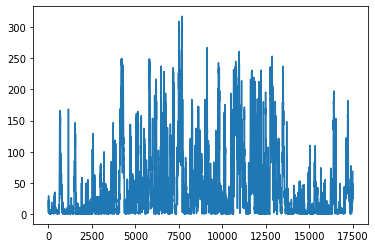

In [70]:
plt.plot(list_y_pred[5][0])

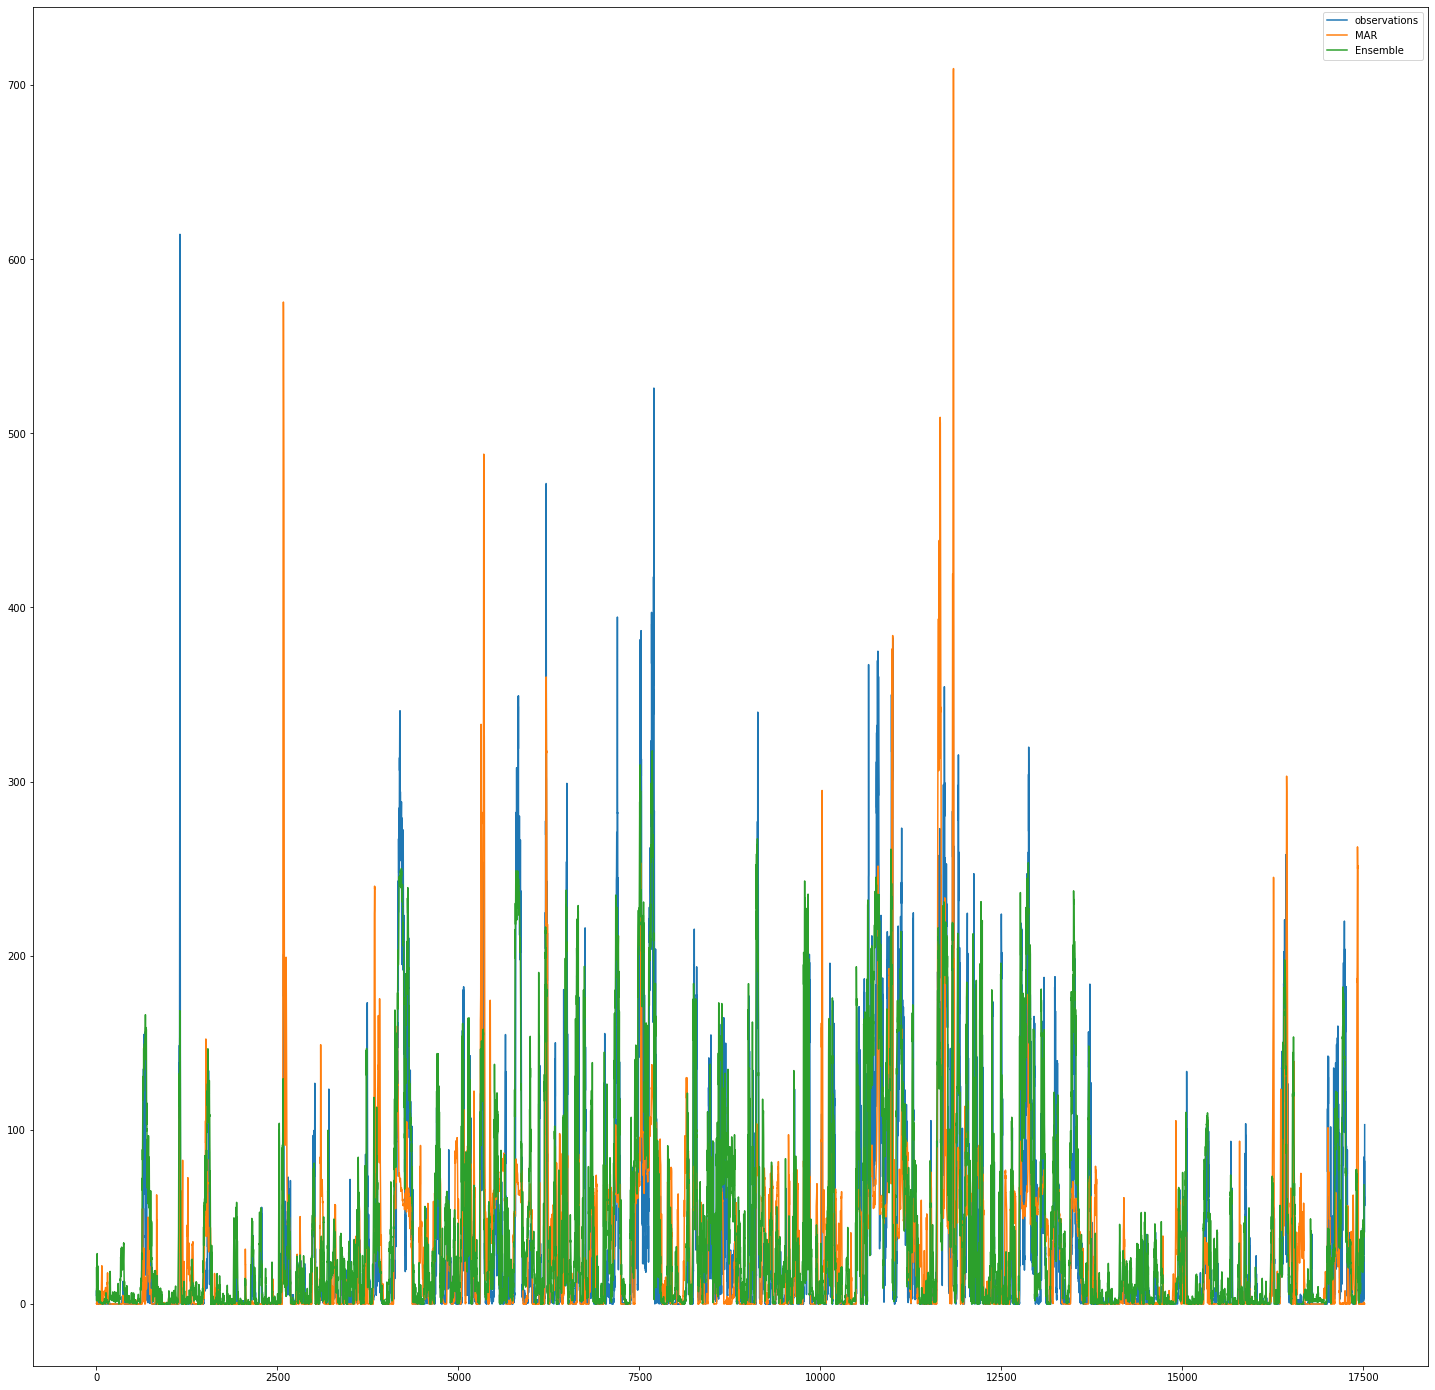

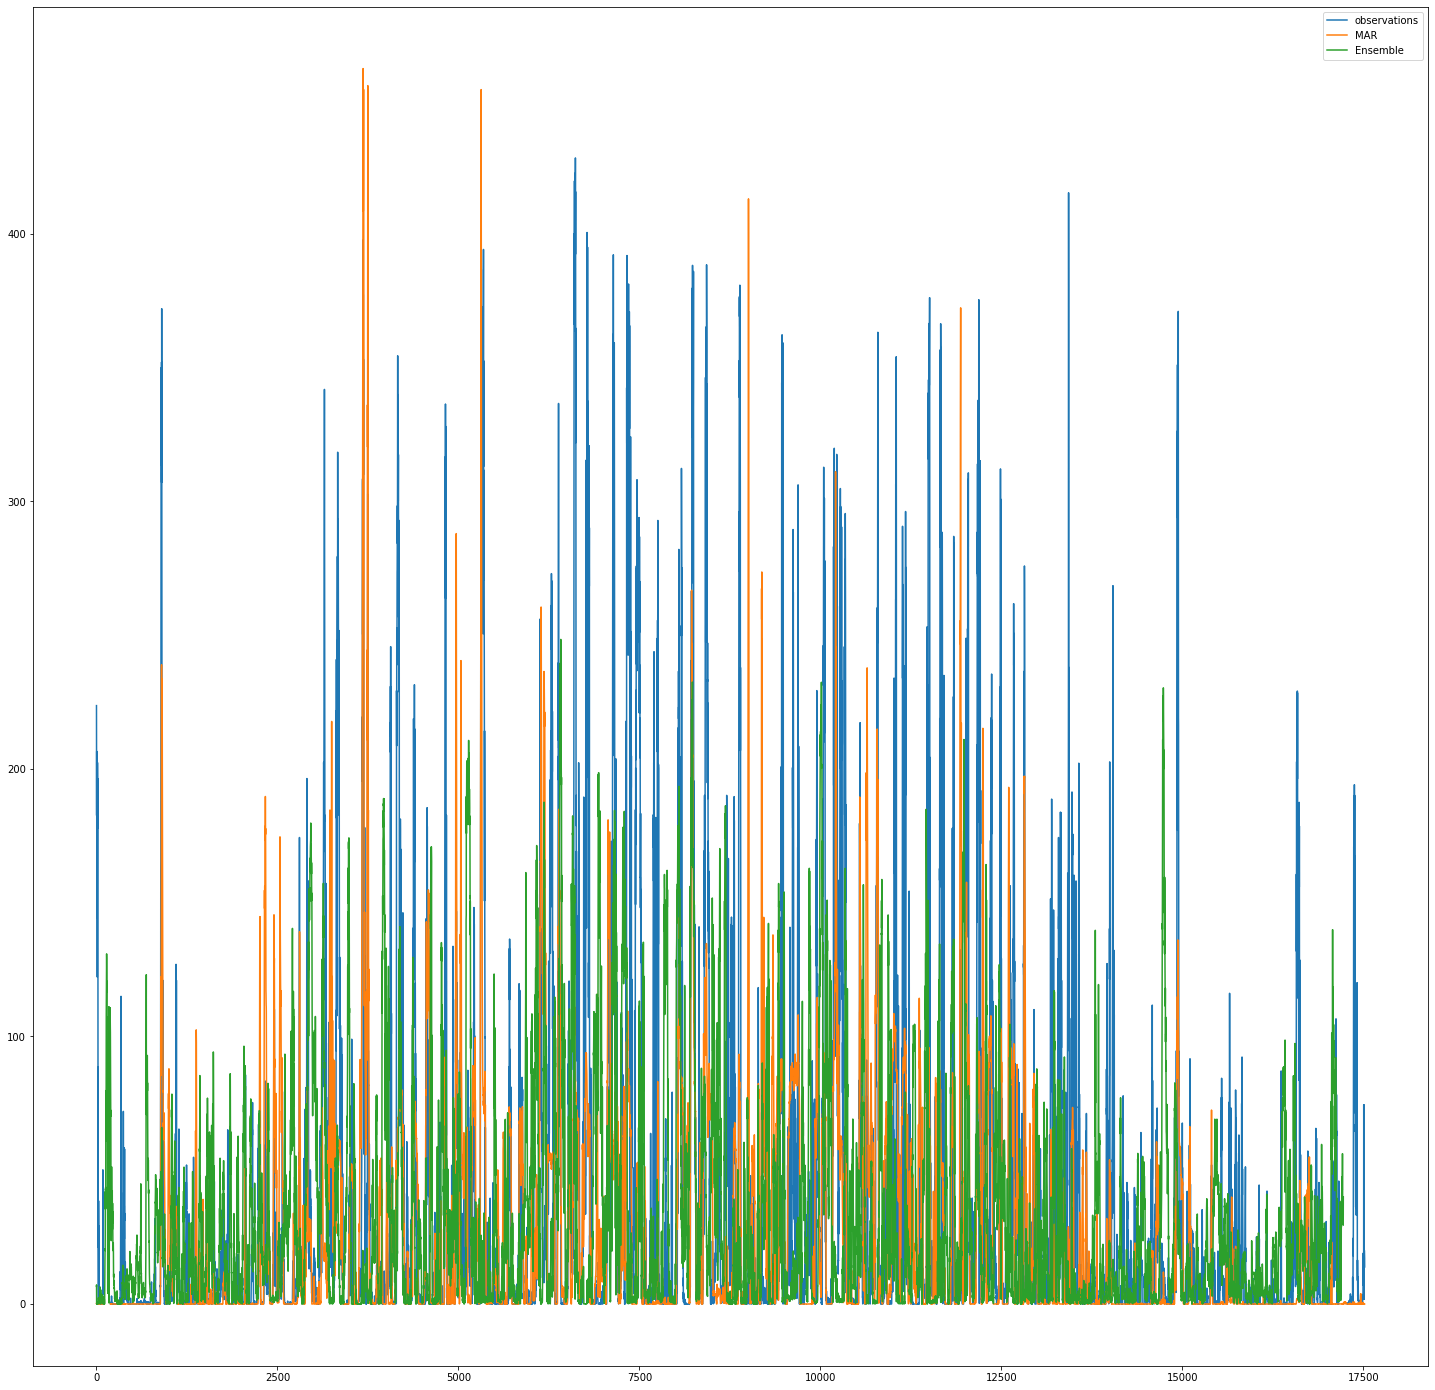

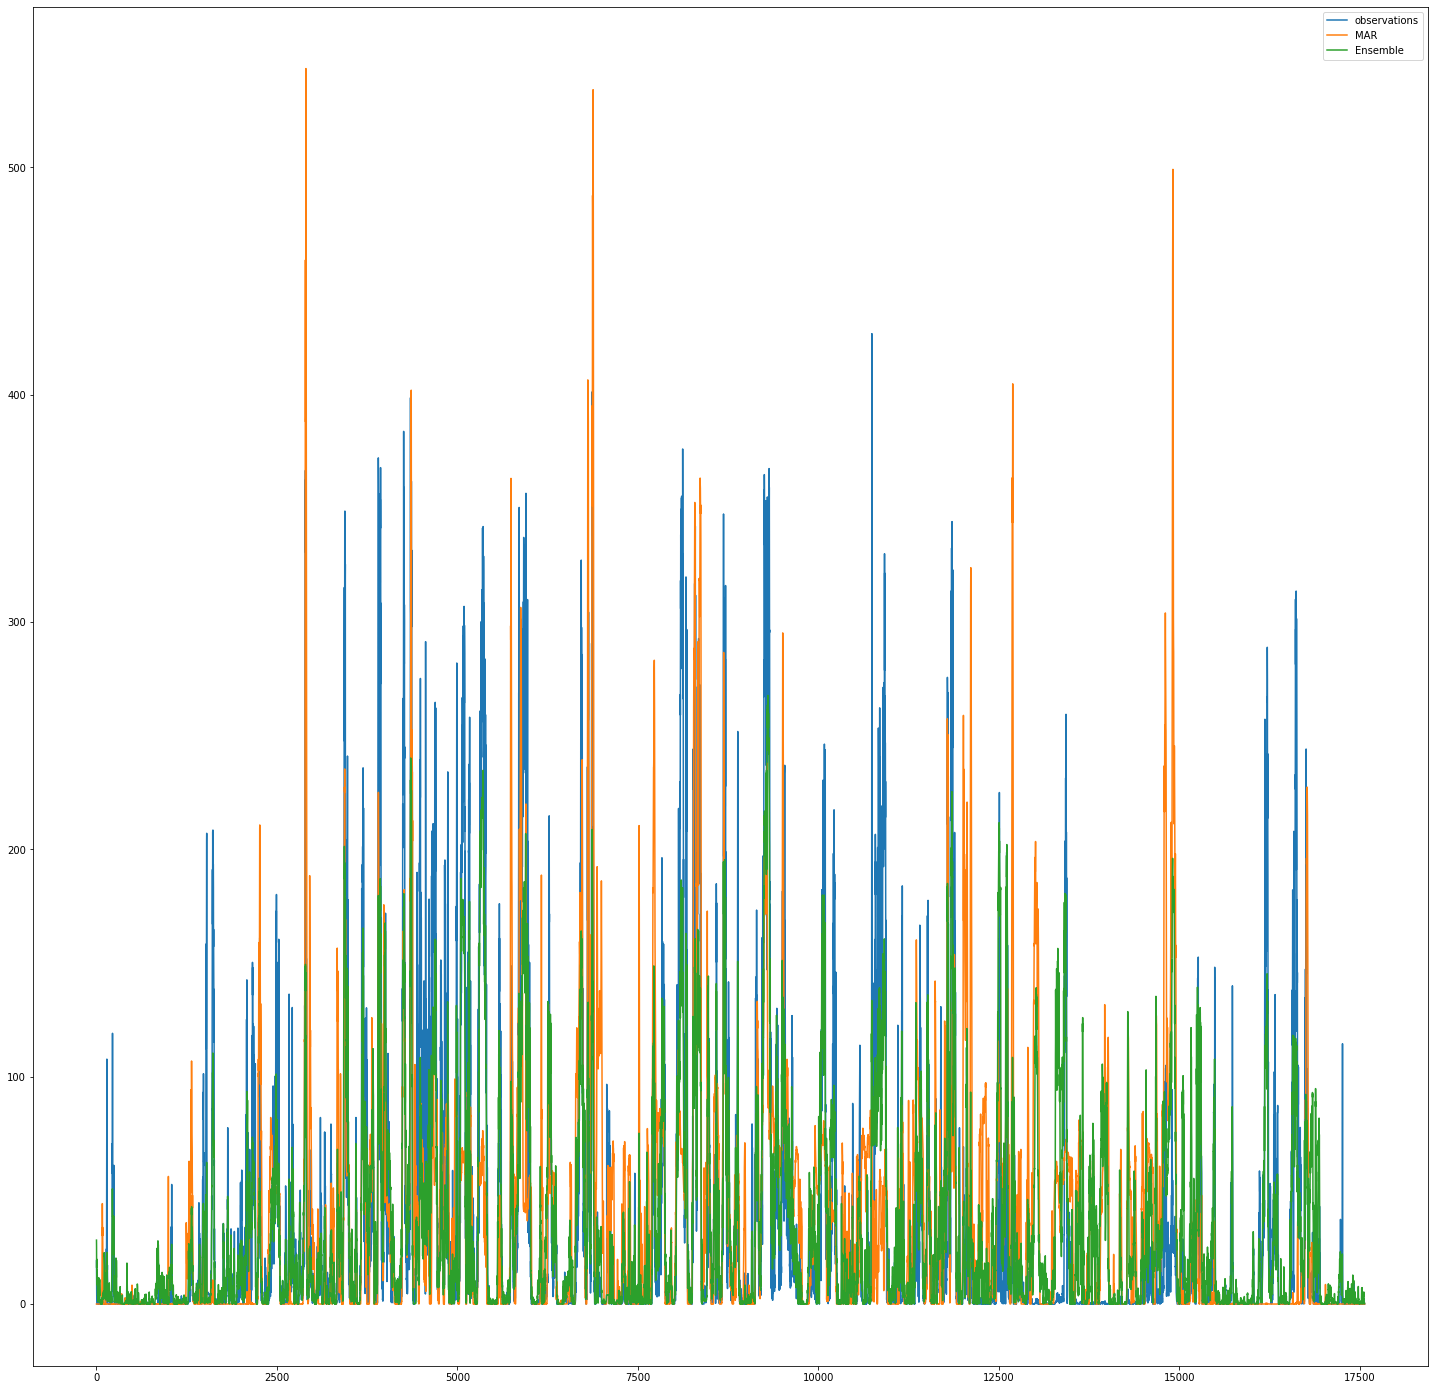

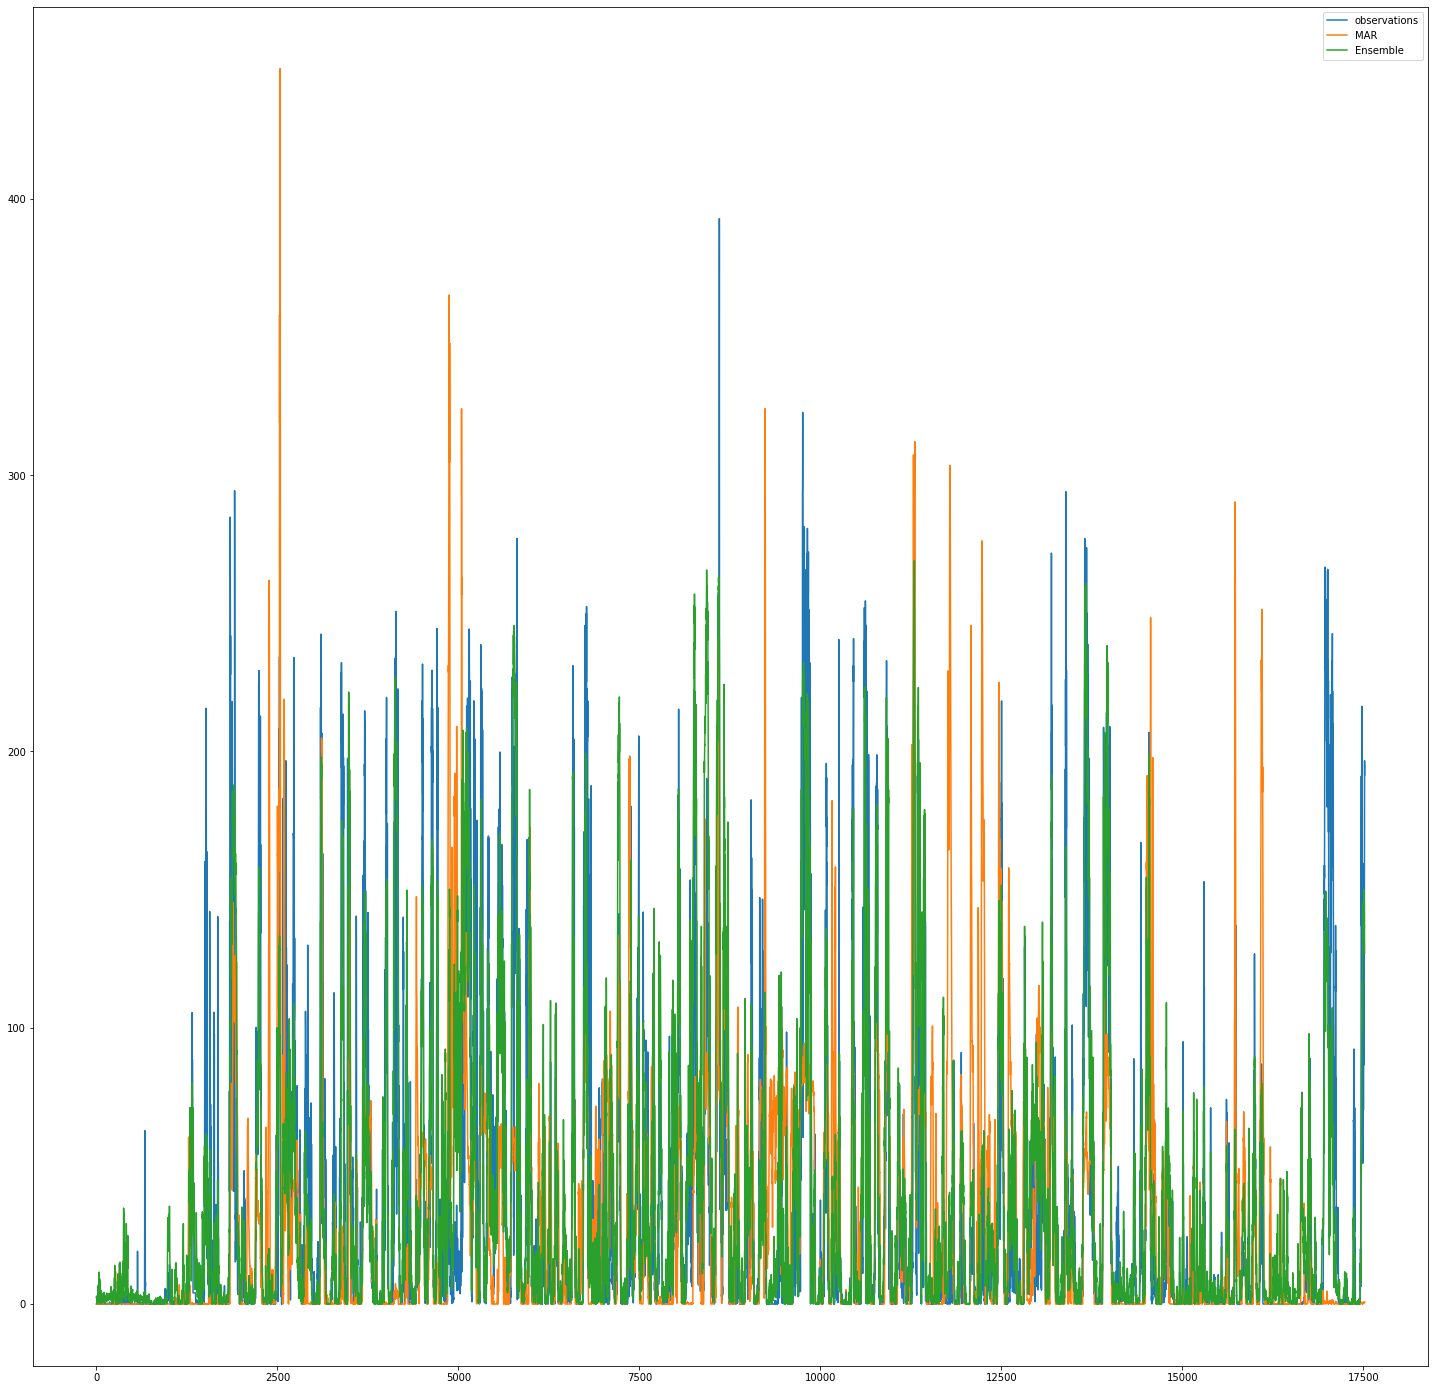

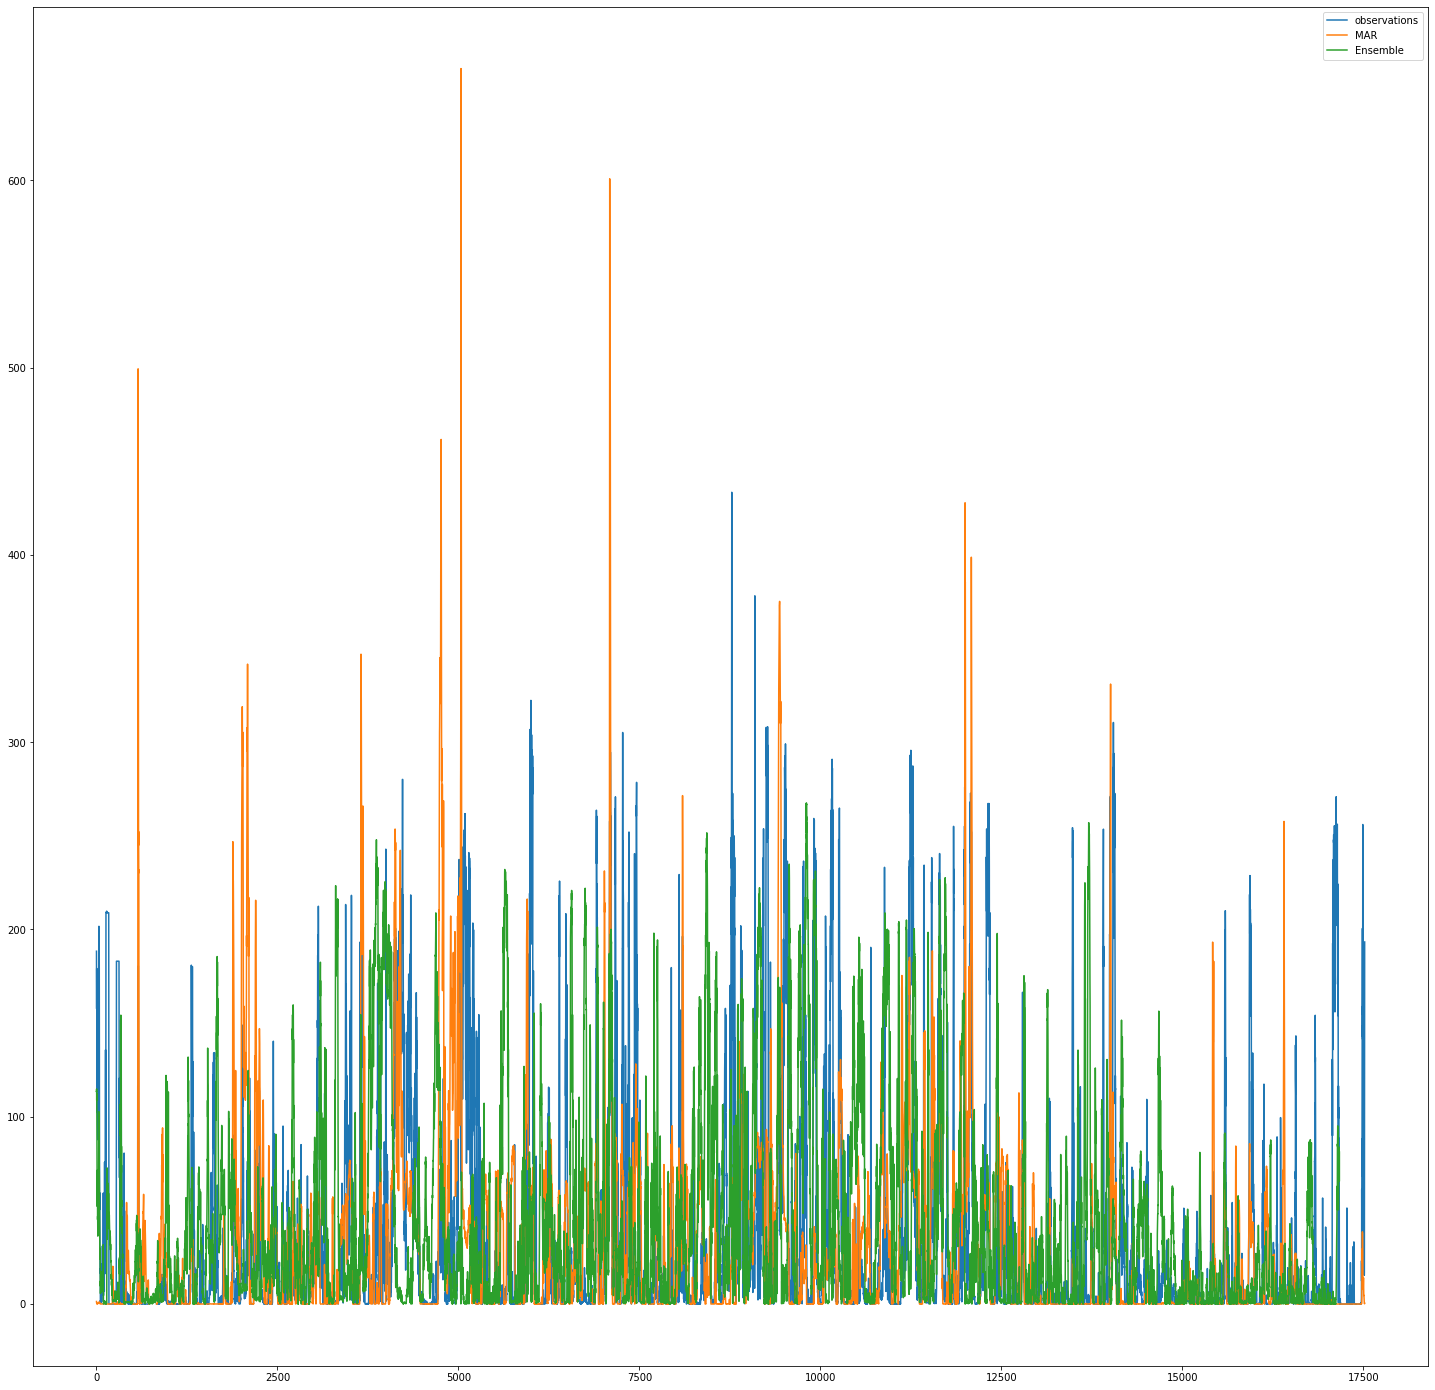

In [71]:
list_model = ['Lasso', 'Polynomial', 'Random Forest', 'DNN', 'MAR', 'Ensemble']
number_model = len(list_model)
list_year = [2013,2015,2016,2017,2018]
i = 0

for year in list_year:
    plt.figure(figsize=(25,25))
    ax = plt.gca()

    observation = D17_observations['FC_2'][(D17_observations.index.year == year)]
    mar_model = MAR['FC'][(MAR.index.year == year)]
    plt.plot(observation.values, label='observations')
    plt.plot(mar_model.values, label='MAR')

    for k in range(5, number_model):
        model = list_y_pred[k][i]
        plt.plot(model, label=list_model[k])
        ax.legend()

    i = i + 1

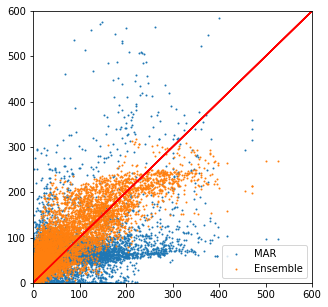

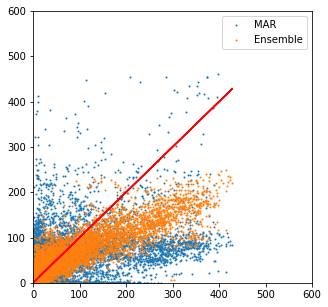

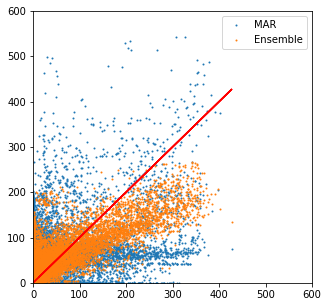

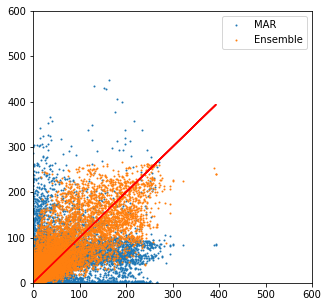

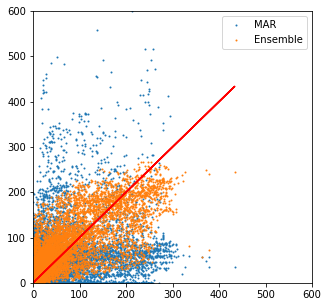

In [72]:
list_model = ['Lasso', 'Polynomial', 'Random Forest', 'DNN', 'MAR', 'Ensemble']
number_model = len(list_model)
list_year = [2013,2015,2016,2017,2018]
i = 0

for year in list_year:
  plt.figure(figsize=(5,5))
  ax = plt.gca()

  observation = D17_observations['FC_2'][(D17_observations.index.year == year) & (D17_observations.index.isin(list_index[i]))]
  mar_model = MAR['FC'][(MAR.index.year == year) & (MAR.index.isin(list_index[i]))]

  for k in range(4, number_model):
    model = list_y_pred[k][i]
    plt.scatter(observation.values, model, s=1, label=list_model[k])
    plt.plot(observation, observation, color='red')
    plt.xlim(0,600)
    plt.ylim(0,600)

  
  #plt.scatter(observation.values, mar_model.values, s=1, label='MAR')
  ax.legend()
  
  i = i + 1

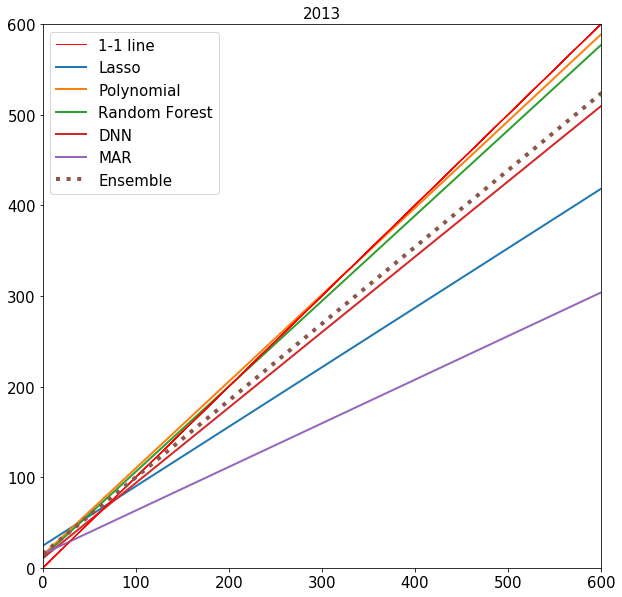

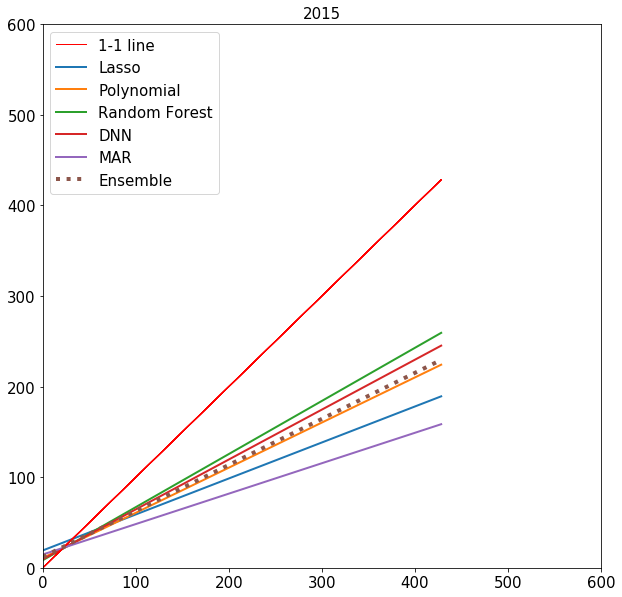

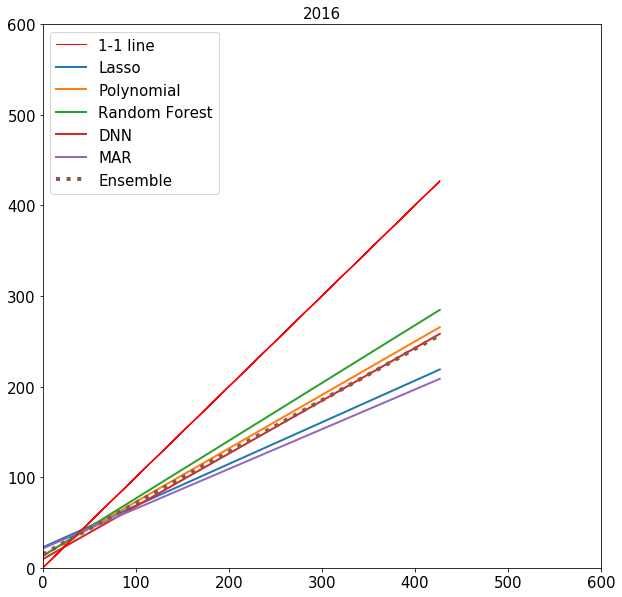

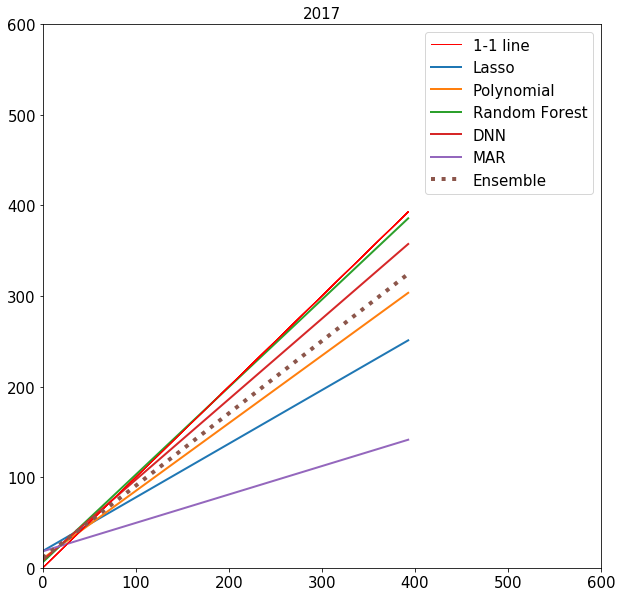

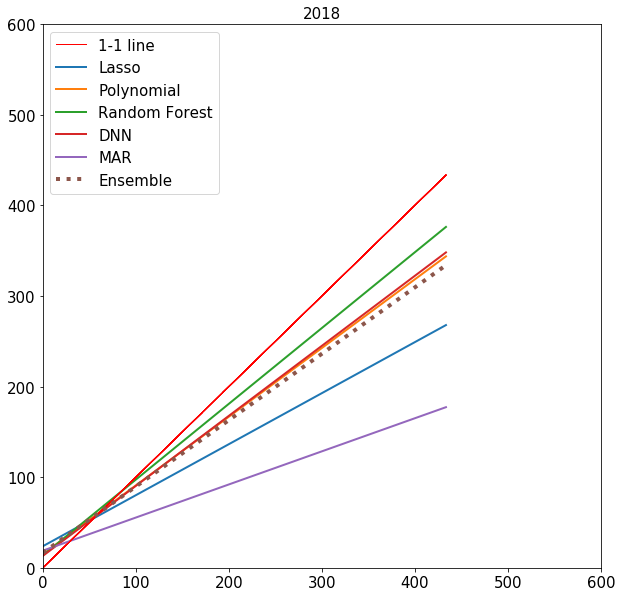

In [125]:
list_model = ['Lasso', 'Polynomial', 'Random Forest', 'DNN', 'MAR', 'Ensemble']
number_model = len(list_model)
list_year = [2013,2015,2016,2017,2018]
i = 0
degree = 1
        
        
        
for year in list_year:
    plt.figure(figsize=(10,10))
    ax = plt.gca()

    observation = D17_observations['FC_2'][(D17_observations.index.year == year) & (D17_observations.index.isin(list_index[i]))]
    mar_model = MAR['FC'][(MAR.index.year == year) & (MAR.index.isin(list_index[i]))]
    x = observation.values
    
    for k in range(number_model):
        model = list_y_pred[k][i]
        
        if k ==0:
            plt.plot(observation, observation, color='red', linewidth=1, label ='1-1 line')
        else:
            plt.plot(observation, observation, color='red', linewidth=1)
        
        plt.xlim(0,600)
        plt.ylim(0,600)
        
        
        if type(list_y_pred[k][i]) == pd.core.frame.DataFrame:
            y = model.values
        else:
            y = model
        
        x1 = x.reshape(-1,1)
        y1 = y.reshape(-1,1)
        
        def polyfit(d):
            polyn = PolynomialFeatures(degree=d)
            x_ = polyn.fit_transform(x1) #x_ contient les degrés et produits croisés
            #Une fois qu'on a préparé les degrés on peut faire la régression
            clf = LinearRegression()
            regression = clf.fit(x_,y1)
            y2 = clf.predict(x_)
            #print('degree ' + str(degree) + ' and MSE ' + str(mean_squared_error(y1, y2)))
            #print(regression.coef_, regression.intercept_)
            return y2, mean_squared_error(y1, y2), regression.coef_,  regression.intercept_

        fonction, mse, coef, intercept = polyfit(degree)
        coef = coef[0][1]
        intercept = intercept[0]
        fonction1 = fonction
        r2 = round(r2_score(y1, fonction),2)
        x1 = sorted(x1)
        fonction = sorted(fonction)
        
        if k == 5:
            plt.plot(x1,fonction, linewidth=4, label=list_model[k], linestyle=':')
        else:
            plt.plot(x1,fonction, linewidth=2, label=list_model[k])
            
    plt.title(year, fontsize=15)

    ax.legend(fontsize=15)
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)

    i = i + 1




# Test computing device

In [ ]:
if 'COLAB_TPU_ADDR' not in os.environ:
  print('ERROR: Not connected to a TPU runtime; please see the first cell in this notebook for instructions!')
else:
  tpu_address = 'grpc://' + os.environ['COLAB_TPU_ADDR']
  print ('TPU address is', tpu_address)


In [ ]:
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

In [ ]:
!nvidia-smi

In [ ]:
tf.test.gpu_device_name()

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


In [ ]:
%tensorflow_version 2.x
import tensorflow as tf

In [ ]:
df_rmse1.to_pickle("df_rmse1.pkl")
list_y_pred.to_pickle("list_y_pred.pkl")